
# CNN Forecasting

**Goal.** Train and evaluate an CNN to predict **next‑day Closevv-EOD price** for a single ticker, using four predefined indicator sets.  
We:

1. Load config & data; enforce reproducibility.
2. Impute missing values (median) → add indicators → impute again.
3. (Optional) Check **stationarity** (ADF) and add stationary transforms for inspection.
4. Build **Target = Close(t+1)**.
5. Train/evaluate four indicator sets; pick the **best by Directional Accuracy** (DA).
6. Re‑train best set and produce **CNN‑style plots**.
7. Compute **permutation feature importance** (metric = DA).  
8. (Optional) Run drop‑column retrain analysis (slower).


## 0) Imports, logging, and random seeds

In [1]:
import os, random, yaml, logging
import numpy as np, pandas as pd, tensorflow as tf
from data_loader import load_stock_data
from indicators import add_indicators
from preprocessing import normalize_features, df_to_windowed_df, windowed_df_to_date_X_y
from model import build_cnn_model
from evaluation import plot_predictions, plot_test_zoomed, compute_metrics, compute_directional_accuracy, evaluate_multi_horizon_accuracy, evaluate_directional_accuracy_by_horizon, simulate_pnl
from feature_analysis import feature_drop_analysis
from evaluation_tables import create_evaluation_tables
from preprocessing import impute_numeric_median, stationarity_report

# Load configuration
with open("config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Set random seeds
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)




# unified plotting

In [2]:
# === Unified plotting utilities ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from run_saver import RunSaver  # Ensure the correct class is imported from the module

def _ensure_datetime(dates):
    """Return a pandas.DatetimeIndex from list/array/Series of dates."""
    if isinstance(dates, (pd.DatetimeIndex, pd.Timestamp)):
        return dates
    try:
        return pd.to_datetime(dates)
    except Exception:
        # If your dates are indices from windowing, fall back to a simple range
        return pd.to_datetime(pd.Series(range(len(dates))), unit="D", origin="unix")

def _style_dates(ax):
    """Consistent, readable date axis."""
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    for label in ax.get_xticklabels():
        label.set_rotation(0)

def plot_predictions(dates_train, y_train, train_pred,
                     dates_val, y_val, val_pred,
                     dates_test, y_test, test_pred,
                     title="Model Predictions (Train/Val/Test)",
                     save_path=None):
    """Unified prediction overlay with consistent style."""
    dt_train = _ensure_datetime(dates_train)
    dt_val   = _ensure_datetime(dates_val)
    dt_test  = _ensure_datetime(dates_test)

    plt.figure(figsize=(14, 6))
    # Train
    plt.plot(dt_train, y_train, linewidth=1.5, label="Train Actual")
    plt.plot(dt_train, train_pred, linewidth=1.5, linestyle="--", label="Train Predicted")
    # Val
    plt.plot(dt_val, y_val, linewidth=1.5, label="Val Actual")
    plt.plot(dt_val, val_pred, linewidth=1.5, linestyle="--", label="Val Predicted")
    # Test
    plt.plot(dt_test, y_test, linewidth=1.8, label="Test Actual")
    plt.plot(dt_test, test_pred, linewidth=1.8, linestyle="--", label="Test Predicted")

    ax = plt.gca()
    _style_dates(ax)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=3)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()

def plot_test_zoomed(dates_test, y_test, test_pred, last_n=120,
                     title="Test Set (Zoomed)",
                     save_path=None):
    """Zoom into last N test points with same style."""
    dt_test = _ensure_datetime(dates_test)
    if last_n is not None and last_n < len(dt_test):
        dt_test = dt_test[-last_n:]
        y_test = y_test[-last_n:]
        test_pred = test_pred[-last_n:]

    plt.figure(figsize=(14, 5))
    plt.plot(dt_test, y_test, linewidth=1.8, label="Test Actual")
    plt.plot(dt_test, test_pred, linewidth=1.8, linestyle="--", label="Test Predicted")

    ax = plt.gca()
    _style_dates(ax)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()

def plot_direction_accuracy_bars(dates_test, y_test, test_pred,
                                 title="Next-Day Direction Prediction Accuracy",
                                 save_path=None):
    """
    Green bar if sign(diff) matches, red if not. Uses the shared date styling.
    """
    dt_test = _ensure_datetime(dates_test)

    true_diff = np.diff(y_test)
    pred_diff = np.diff(test_pred)
    true_dir  = np.sign(true_diff)
    pred_dir  = np.sign(pred_diff)
    correct   = (true_dir == pred_dir)
    # Align dates due to diff
    dt_bars = dt_test[1:]

    colors = np.where(correct, "tab:green", "tab:red")
    plt.figure(figsize=(14, 3.5))
    plt.bar(dt_bars, true_dir, width=1, color=colors)
    plt.axhline(0, linewidth=1, linestyle="--")
    ax = plt.gca()
    _style_dates(ax)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Direction (+1 / -1)")
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()



# === Extra plots: delta scatter & correlation heatmap ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_delta_scatter_painted(
    dates, actual, predicted,
    title="Delta Scatter (Predicted - Actual)",
    save_path=None,
    rolling_window=7,
    top_k_annotate=3,
    color_by="sign",          # "sign" or "direction"
    add_summary=True,
):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.dates as mdates
    from matplotlib.lines import Line2D

    dt = pd.to_datetime(dates)
    y  = np.asarray(actual).ravel()
    yhat = np.asarray(predicted).ravel()
    delta = yhat - y

    # Direction correctness (T+1 deltas)
    true_diff = np.diff(y)
    pred_diff = np.diff(yhat)
    correct = (np.sign(true_diff) == np.sign(pred_diff))
    dt2, delta2 = dt[1:], delta[1:]

    # Size by magnitude
    mag = np.abs(delta2)
    p90 = np.nanpercentile(mag, 90) if mag.size else 1.0
    sizes = 14 + 60 * (mag / (p90 + 1e-9))**0.7

    # Color & marker encoding
    if color_by == "sign":
        colors = np.where(delta2 >= 0, "tab:green", "tab:red")
        markers = np.array(["o"]*len(delta2))
        legend_handles = [
            Line2D([0], [0], marker='o', color='w', label='Over-prediction (Δ ≥ 0)',
                   markerfacecolor='tab:green', markeredgecolor='white', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Under-prediction (Δ < 0)',
                   markerfacecolor='tab:red', markeredgecolor='white', markersize=8),
        ]
    else:
        colors = np.where(correct, "tab:green", "tab:red")
        markers = np.where(correct, "o", "X")  # circle if correct, X if wrong
        legend_handles = [
            Line2D([0], [0], marker='o', color='w', label='Correct direction',
                   markerfacecolor='tab:green', markeredgecolor='white', markersize=8),
            Line2D([0], [0], marker='X', color='w', label='Wrong direction',
                   markerfacecolor='tab:red', markeredgecolor='white', markersize=8),
        ]

    # Plot (draw in two groups so shapes render)
    plt.figure(figsize=(14, 5))
    for mk in np.unique(markers):
        msk = (markers == mk)
        plt.scatter(dt2[msk], delta2[msk], s=sizes[msk], c=colors[msk],
                    alpha=0.9, edgecolors="white", linewidths=0.6, marker=mk)

    plt.axhline(0, linestyle="--", linewidth=1, color="0.5")

    # Rolling mean overlay (on full delta)
    if rolling_window and rolling_window > 1:
        roll = pd.Series(delta, index=dt).rolling(rolling_window).mean()
        plt.plot(roll.index, roll.values, linewidth=1.6, alpha=0.95, label=f"Rolling mean Δ ({rolling_window})")

    # 5/95% bands on aligned series
    if len(delta2) > 1:
        q5, q95 = np.nanquantile(delta2, [0.05, 0.95])
        plt.axhline(q5, linestyle=":", linewidth=1, color="0.4")
        plt.axhline(q95, linestyle=":", linewidth=1, color="0.4")

    # Label top-|Δ|
    if top_k_annotate and len(delta2) > 0:
        top_idx = np.argsort(-np.abs(delta2))[:top_k_annotate]
        for i in top_idx:
            plt.annotate(
                dt2[i].strftime("%Y-%m-%d"), (dt2[i], delta2[i]),
                xytext=(6, 6), textcoords="offset points",
                fontsize=8, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.7", alpha=0.8)
            )

    # Date axis
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax = plt.gca()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    if rolling_window and rolling_window > 1:
        legend_handles.append(Line2D([0], [0], color='C0', lw=1.6, label=f"Rolling mean Δ ({rolling_window})"))
    plt.legend(handles=legend_handles, loc="upper left")

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Delta (Pred - Actual)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()

    if add_summary and len(delta2) > 0:
        print(f"[delta] mean={np.mean(delta2):.3f}, std={np.std(delta2):.3f}, "
              f"q05={np.nanquantile(delta2,0.05):.3f}, q95={np.nanquantile(delta2,0.95):.3f}, n={len(delta2)}")



def compute_corr_matrix_for_set(df, feat_cols, include_target=True, target_col="Target"):
    """
    Returns Pearson correlation matrix for selected features (+Target).
    Uses the ORIGINAL (unscaled) df you trained from (post-imputation).
    """
    cols = list(feat_cols)
    if include_target and target_col in df.columns:
        cols = cols + [target_col]
    # only numeric
    nums = df[cols].select_dtypes(include=[np.number]).copy()
    # drop all-NaN or constant columns to avoid NaNs in corr
    nunique = nums.nunique(dropna=True)
    keep = nunique[nunique > 1].index.tolist()
    nums = nums[keep]
    corr = nums.corr(method="pearson")
    return corr

from matplotlib.colors import LinearSegmentedColormap

def plot_corr_heatmap(corr_df, title="Correlation Heatmap (Salmon)", save_path=None):
    """
    Diverging heatmap centered at 0 using a custom 'salmon' palette.
    Annotates each cell with the correlation value.
    """
    labels = corr_df.columns.tolist()
    mat = corr_df.values

    # Build a diverging 'salmon' style colormap (blue -> white -> salmon)
    salmon_div = LinearSegmentedColormap.from_list(
        "salmon_div",
        ["#3B82F6", "#F8FAFC", "#FA8072", "#7F1D1D"],  # blue -> near white -> salmon -> dark red
        N=256
    )

    plt.figure(figsize=(1.1*len(labels)+2, 1.1*len(labels)+2))
    im = plt.imshow(mat, vmin=-1, vmax=1, cmap=salmon_div, aspect="auto")

    # Colorbar
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("ρ", rotation=0, labelpad=10)

    # Ticks & labels
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)

    # Annotate each cell
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            v = mat[i, j]
            # Contrast-aware text color
            txtc = "white" if abs(v) > 0.5 else "black"
            plt.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9, color=txtc)

    plt.title(title)
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()




def plot_pred_vs_actual(actual, predicted, title="Predicted vs Actual", save_path=None):
    import numpy as np, matplotlib.pyplot as plt, os
    y = np.asarray(actual).ravel(); yhat = np.asarray(predicted).ravel()
    lims = [min(y.min(), yhat.min()), max(y.max(), yhat.max())]

    plt.figure(figsize=(6,6))
    plt.scatter(y, yhat, s=10, alpha=0.7, edgecolors="white", linewidths=0.4)
    plt.plot(lims, lims, ls="--", lw=1, color="0.4")  # 45° line
    plt.title(title); plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.grid(True, alpha=0.3); plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()




In [3]:
# ====  CSV logging helpers ====
import os, datetime as dt
import pandas as pd
import numpy as np
with open("config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

RESULT_FILE_CNN = config["paths"].get("result_file_CNN", "results/CNN_results.csv")
os.makedirs(os.path.dirname(RESULT_FILE_CNN), exist_ok=True)
os.makedirs("output/predictions", exist_ok=True)

def _mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def _split_metrics(dates, y_true, y_pred):
    """Return metrics dict for one split."""
    from evaluation import compute_metrics, compute_directional_accuracy
    rmse, mae = compute_metrics(y_true, y_pred)
    mape = _mape(y_true, y_pred)
    da   = compute_directional_accuracy(y_true, y_pred)
    return {
        "n": int(len(y_true)),
        "rmse": float(rmse),
        "mae": float(mae),
        "mape": float(mape),
        "da": float(da),
        "start_date": pd.to_datetime(dates[0]).date() if len(dates) else None,
        "end_date":   pd.to_datetime(dates[-1]).date() if len(dates) else None,
    }

def _ensure_results_csv(path):
    """Create the master results CSV with a header if missing."""
    if not os.path.exists(path):
        cols = [
            "timestamp","ticker","model","feature_set","k",
            "window_size","epochs","batch_size","learning_rate",
            "train_end","val_end","split","n",
            "rmse","mae","mape","da","start_date","end_date"
        ]
        pd.DataFrame(columns=cols).to_csv(path, index=False)

def save_CNN_run_tables(
    ticker, best_name, feature_names,
    # splits
    d_tr, y_tr_true, y_tr_pred,
    d_va, y_va_true, y_va_pred,
    d_te, y_te_true, y_te_pred,
    # hyperparams
    window_size, epochs, batch_size, learning_rate,
    train_end, val_end,
    result_file=RESULT_FILE_CNN,
):
    """
    1) Append split metrics rows (Train/Val/Test) to results/cnn_results.csv
    2) Save a predictions CSV with all splits concatenated
    """
    _ensure_results_csv(result_file)
    now = dt.datetime.utcnow().isoformat()

    # --- metrics rows (one per split) ---
    rows = []
    for split, dates, yt, yp in [
        ("Train", d_tr, y_tr_true, y_tr_pred),
        ("Val",   d_va, y_va_true, y_va_pred),
        ("Test",  d_te, y_te_true, y_te_pred),
    ]:
        m = _split_metrics(dates, yt, yp)
        rows.append({
            "timestamp": now,
            "ticker": ticker,
            "model": "cnn",
            "feature_set": best_name,
            "k": len(feature_names),
            "window_size": window_size,
            "epochs": epochs,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "train_end": train_end,
            "val_end": val_end,
            "split": split,
            "n": m["n"],
            "rmse": m["rmse"],
            "mae": m["mae"],
            "mape": m["mape"],
            "da": m["da"],
            "start_date": m["start_date"],
            "end_date": m["end_date"],
        })

    pd.DataFrame(rows).to_csv(result_file, mode="a", header=False, index=False)
    print(f"✅ Appended CNN metrics to: {result_file}")



    # --- predictions table (all splits stacked) ---
    def _pred_df(split, dates, yt, yp):
        yt = np.asarray(yt).flatten()
        yp = np.asarray(yp).flatten()
        d  = pd.to_datetime(pd.Index(dates))
        delta = yp - yt
        # correct direction relative to next-day move (sign of diff)
        true_dir = np.sign(np.diff(yt, prepend=yt[0]))      # prepend to keep length
        pred_dir = np.sign(np.diff(yp, prepend=yp[0]))
        return pd.DataFrame({
            "Date": d,
            "Split": split,
            "Actual": yt,
            "Predicted": yp,
            "Delta": delta,
            "CorrectDirection": (true_dir == pred_dir).astype(int)
        })

    pred_all = pd.concat([
        _pred_df("Train", d_tr, y_tr_true, y_tr_pred),
        _pred_df("Val",   d_va, y_va_true, y_va_pred),
        _pred_df("Test",  d_te, y_te_true, y_te_pred),
    ], ignore_index=True)

    pred_path = f"output/predictions/{ticker}_{best_name}_predictions.csv"
    pred_all.to_csv(pred_path, index=False)
    print(f"✅ Saved predictions table: {pred_path}")


# call this helper inside your evaluation loop:
def append_per_set_summary(
    ticker, set_name, k, da_val, rmse_val, mae_val, mape_val,
    da_test, rmse_test, mae_test, mape_test,
    window_size, epochs, batch_size, learning_rate,
    train_end, val_end,
    result_file=RESULT_FILE_CNN,
):
    _ensure_results_csv(result_file)
    now = dt.datetime.utcnow().isoformat()
    # We write two rows (Val/Test) under the same set+hyperparams for easy pivoting later
    pd.DataFrame([
        dict(timestamp=now, ticker=ticker, model="cnn", feature_set=set_name, k=k,
             window_size=window_size, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             train_end=train_end, val_end=val_end, split="Val", n=np.nan,
             rmse=rmse_val, mae=mae_val, mape=mape_val, da=da_val, start_date=None, end_date=None),
        dict(timestamp=now, ticker=ticker, model="cnn", feature_set=set_name, k=k,
             window_size=window_size, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             train_end=train_end, val_end=val_end, split="Test", n=np.nan,
             rmse=rmse_test, mae=mae_test, mape=mape_test, da=da_test, start_date=None, end_date=None),
    ]).to_csv(result_file, mode="a", header=False, index=False)

def save_split_metrics_table(
    set_name, ticker,
    d_tr, tr_true, tr_pred,
    d_va, va_true, va_pred,
    d_te, te_true, te_pred,
    out_dir="output/sets"
):
    """Create a tidy per-split metrics table (RMSE/MAE/MAPE/DA), print it, and save CSV."""
    rmse_tr, mae_tr = compute_metrics(tr_true, tr_pred)
    rmse_va, mae_va = compute_metrics(va_true, va_pred)
    rmse_te, mae_te = compute_metrics(te_true, te_pred)

    def _mape_local(y, yhat):
        eps = 1e-8
        y = np.asarray(y, float); yhat = np.asarray(yhat, float)
        return float(np.mean(np.abs((y - yhat) / np.maximum(np.abs(y), eps))) * 100.0)

    m = pd.DataFrame([
        dict(Split="Train", RMSE=rmse_tr, MAE=mae_tr, MAPE=_mape_local(tr_true, tr_pred), DA=compute_directional_accuracy(tr_true, tr_pred), n=len(tr_true)),
        dict(Split="Val",   RMSE=rmse_va, MAE=mae_va, MAPE=_mape_local(va_true, va_pred), DA=compute_directional_accuracy(va_true, va_pred), n=len(va_true)),
        dict(Split="Test",  RMSE=rmse_te, MAE=mae_te, MAPE=_mape_local(te_true, te_pred), DA=compute_directional_accuracy(te_true, te_pred), n=len(te_true)),
    ])
    print("\n[metrics table]")
    print(m.round(4).to_string(index=False))

    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, f"{ticker}_{set_name}_metrics.csv")
    m.to_csv(path, index=False)
    try:
        saver.save_df(m, f"metrics_{set_name}")  # also into run folder
    except Exception:
        pass
    print(f"[save] Metrics CSV → {path}")
    return m



## 2) Load config & set split percentages

In [4]:
import os, yaml
from pathlib import Path

# ---- load config safely ----
with open("config/config.yaml", "r") as f:
    config = yaml.safe_load(f) or {}

# ---- splits (with sane defaults) ----
sp = config.get("split", {}) or {}
TRAIN_END = float(sp.get("train_end", 0.85))
VAL_END   = float(sp.get("val_end",   0.92))
if VAL_END <= TRAIN_END:  # simple guard
    VAL_END = min(0.98, TRAIN_END + 0.05)
    print(f"[warn] val_end <= train_end; adjusted VAL_END to {VAL_END:.2f}")

# ---- modeling params (CNN) ----
cnn_cfg       = config.get("cnn", {}) or {}
window_size   = int(cnn_cfg.get("window_size", 60)) # set default
epochs        = int(cnn_cfg.get("epochs", 30)) # set default
batch_size    = int(cnn_cfg.get("batch_size", 32)) # set default
learning_rate = float(cnn_cfg.get("learning_rate", 1e-3)) # set default 

# ---- stationarity flags (legacy + current) ----
USE_STATIONARY_FEATURES = bool(config.get("features", {}).get("stationary", False)) # set default 
USE_STATIONARITY        = bool(config.get("stationarity", {}).get("enable", False)) # set default 

# ---- ticker & paths ----
tickers    = config.get("tickers") or []
ticker     = str(tickers[0]) if len(tickers) > 0 else str(config.get("ticker", "AAPL"))
paths      = config.get("paths", {}) or {}
csv_folder = paths.get("csv_folder", "data/csv")
model_dir  = paths.get("model_folder_cnn", "models/cnn")
Path("output").mkdir(parents=True, exist_ok=True)
Path(model_dir).mkdir(parents=True, exist_ok=True)

print("Ticker:", ticker)
print("Split (train_end, val_end):", TRAIN_END, VAL_END)
print(f"CNN params -> window_size={window_size}, epochs={epochs}, batch_size={batch_size}, lr={learning_rate}")

# ---- RunSaver (no environment dump) ----
from run_saver import RunSaver  

saver = RunSaver(model_name="CNN", ticker=ticker)   # Instantiate the RunSaver class
saver.save_config(config)                           # snapshot only; no TF/system env saved
saver.note(
    f"Initialized run for {ticker} | splits=({TRAIN_END},{VAL_END}) | "
    f"cnn(ws={window_size}, ep={epochs}, bs={batch_size}, lr={learning_rate}) | "
    f"stationarity: legacy={USE_STATIONARY_FEATURES}, new={USE_STATIONARITY}"
)


Ticker: AAPL
Split (train_end, val_end): 0.92 0.96
CNN params -> window_size=10, epochs=60, batch_size=16, lr=0.001


In [5]:
# --- helpers: tolerant path getter + candidate loader ---
from pathlib import Path

def _get_path(paths: dict, *keys, default: str = None) -> str:
    if not isinstance(paths, dict):
        return default
    for k in keys:
        for v in (k, k.lower(), k.upper()):
            if v in paths:
                return paths[v]
    return default

def load_candidate_sets_from_config(cfg: dict, ticker: str):
    cands = {}
    per = (cfg.get("candidates") or {}).get("per_ticker") or {}
    for key, sets in per.items():
        if str(key).strip().lower() == str(ticker).strip().lower():
            for set_name, feat_list in (sets or {}).items():
                cands[str(set_name)] = [str(f).strip() for f in (feat_list or [])]
            break
    return cands

# --- resolve paths robustly (case-insensitive keys) ---
paths = config.get("paths", {}) or {}
csv_folder = _get_path(paths, "csv_folder", default="data/csv")
model_dir  = _get_path(paths, "model_folder_cnn", default="models/cnn")
result_file_cnn = _get_path(paths, "result_file_cnn", "result_file_CNN", default="results/cnn_results.csv")

# ensure dirs exist
Path("output").mkdir(parents=True, exist_ok=True)
Path(model_dir).mkdir(parents=True, exist_ok=True)
Path(Path(result_file_cnn).parent).mkdir(parents=True, exist_ok=True)

print(f"[paths] csv_folder={csv_folder}")
print(f"[paths] model_dir={model_dir}")
print(f"[paths] results={result_file_cnn}")

# --- gentle sanity warnings for splits ---
val_frac  = max(0.0, VAL_END - TRAIN_END)
test_frac = max(0.0, 1.0 - VAL_END)
if val_frac < 0.05:
    print(f"[warn] Validation fraction is small ({val_frac:.2%}). Consider >= 5% for stabler model selection.")
if test_frac < 0.05:
    print(f"[warn] Test fraction is small ({test_frac:.2%}). Consider >= 5% for more reliable reporting.")

# --- load per-ticker candidate sets now (so later code can use it) ---
CANDIDATE_SETS = load_candidate_sets_from_config(config, ticker)
if not CANDIDATE_SETS:
    print("[info] No per-ticker candidates in config; a default 4-set fallback will be used later.")


[paths] csv_folder=stock_data_histogram
[paths] model_dir=cnn_models
[paths] results=cnn_results.csv
[warn] Validation fraction is small (4.00%). Consider >= 5% for stabler model selection.
[warn] Test fraction is small (4.00%). Consider >= 5% for more reliable reporting.


## 3) Load data & ensure datetime index

In [6]:
## 3) Load data & ensure datetime index (robust)

# Load data
df = load_stock_data(csv_folder, [ticker])[0]

# --- 3.1 Ensure a clean DatetimeIndex (tz-naive, sorted, unique) ---
def _ensure_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    # If index already datetime, normalize tz; else try common date columns
    if isinstance(df.index, pd.DatetimeIndex):
        idx = df.index
    elif "Date" in df.columns:
        idx = pd.to_datetime(df["Date"], errors="coerce")
        df = df.drop(columns=["Date"])
    elif "date" in df.columns:
        idx = pd.to_datetime(df["date"], errors="coerce")
        df = df.drop(columns=["date"])
    else:
        # last resort: try to parse current index
        idx = pd.to_datetime(df.index, errors="coerce")

    # Make tz-naive for Matplotlib and consistency
    try:
        if getattr(idx, "tz", None) is not None:
            idx = idx.tz_convert(None)  # if tz-aware
    except AttributeError:
        pass  # idx may be plain Index

    df.index = idx
    # Drop NaT index rows
    df = df[~df.index.to_series().isna()]
    # Sort by time
    df = df.sort_index()

    # Deduplicate timestamps (keep last)
    if df.index.has_duplicates:
        dup_ct = df.index.duplicated(keep="last").sum()
        print(f"[warn] Found {dup_ct} duplicate timestamps — keeping last occurrence.")
        df = df[~df.index.duplicated(keep="last")]

    # Sticky copy to recover index later if some helper resets it
    df["__DATE__"] = df.index
    return df

df = _ensure_datetime_index(df)

# --- 3.2 Optional: add missing business days (controlled by config) ---
dcfg = (config.get("data_cleaning") or {})
if bool(dcfg.get("add_missing_business_days", False)):
    full_idx = pd.bdate_range(df.index.min(), df.index.max(), name=df.index.name)
    before = len(df)
    df = df.reindex(full_idx)
    # Keep '__DATE__' aligned
    df["__DATE__"] = df.index
    print(f"[info] Reindexed to business days: {before} → {len(df)} rows (NaNs will be imputed).")

# --- 3.3 Basic numeric coercion & Close check ---
# Coerce obvious numeric columns to numeric (silently sets bad parses to NaN → imputed later)
for col in df.columns:
    if col not in ["__DATE__"]:
        # don’t blindly coerce strings like tickers; most financial cols parse fine
        try:
            df[col] = pd.to_numeric(df[col], errors="ignore")
        except Exception:
            pass

# Drop rows with missing Close only (others will be imputed)
missing_close = df["Close"].isna().sum() if "Close" in df.columns else None
if "Close" not in df.columns:
    raise ValueError("Expected column 'Close' not found in input data.")
if missing_close:
    print(f"[warn] Dropping {missing_close} rows with missing Close.")
    df = df.dropna(subset=["Close"])

print(
    "Data loaded:",
    f"shape={df.shape},",
    f"range=[{df.index.min().date()} .. {df.index.max().date()}],",
    f"freq≈{pd.infer_freq(df.index) or 'irregular'}"
)

# Quick peek
display(df.head(3))
display(df.tail(3))


Data loaded: shape=(1258, 3), range=[2020-01-02 .. 2024-12-31], freq≈irregular


C:\Users\hamir\AppData\Local\Temp\ipykernel_25636\2310491342.py:62: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


,Close,Open,__DATE__
Date,,,
2020-01-02 05:00:00,72.716064,71.721011,2020-01-02 05:00:00
2020-01-03 05:00:00,72.009102,71.941313,2020-01-03 05:00:00
2020-01-06 05:00:00,72.582909,71.127866,2020-01-06 05:00:00


,Close,Open,__DATE__
Date,,,
2024-12-27 05:00:00,255.309296,257.546826,2024-12-27 05:00:00
2024-12-30 05:00:00,251.923019,251.952985,2024-12-30 05:00:00
2024-12-31 05:00:00,250.144974,252.162760,2024-12-31 05:00:00



## 4) Impute, add indicators, impute again


- Impute numeric columns with **median** (robust to outliers).
- Add technical indicators (from `indicators.py`).
- Impute again to remove rolling warm‑up NaNs.

In [7]:
## 4) Impute, add indicators, impute again
from importlib import reload
import indicators
reload(indicators)
from indicators import add_indicators

# First pass: impute (stabilize rolling windows)
df = impute_numeric_median(df)

# Add technical indicators (use YAML windows if present)
ti_cfg = config.get("technical_indicators", {}) or {}
df = add_indicators(df, cfg=ti_cfg)

# Second pass: remove rolling warm-up NaNs via robust median fill
df = impute_numeric_median(df)

# (Optional) Safety: ensure the handful we rely on definitely exist with cfg windows
w_ma  = int(ti_cfg.get("ma_window", 20))
w_bb  = int(ti_cfg.get("bb_window", 20))
bb_k  = float(ti_cfg.get("bb_std", 2))
w_vol = int(ti_cfg.get("vol_window", 20))

if "SMA" not in df.columns:
    df["SMA"] = df["Close"].rolling(window=w_ma).mean()
if "EMA" not in df.columns:
    df["EMA"] = df["Close"].ewm(span=w_ma, adjust=False).mean()
if ("BB_upper" not in df.columns) or ("BB_lower" not in df.columns):
    ma_bb  = df["Close"].rolling(window=w_bb).mean()
    std_bb = df["Close"].rolling(window=w_bb).std()
    df["BB_upper"] = ma_bb + bb_k * std_bb
    df["BB_lower"] = ma_bb - bb_k * std_bb
if "Log_Return" not in df.columns:
    df["Log_Return"] = np.log(df["Close"] / df["Close"].shift(1))
if "RollingVolatility" not in df.columns:
    df["RollingVolatility"] = df["Log_Return"].rolling(window=w_vol).std()

# Final cleanup
df = impute_numeric_median(df)
display(df.tail())


,Close,Open,__DATE__,Log_Return,MACD,RSI,SMA,EMA,BB_upper,BB_lower,RollingVolatility,Momentum
Date,,,,,,,,,,,,
2024-12-24 05:00:00,257.916443,255.209412,2024-12-24 05:00:00,0.011413,6.067327,82.136541,246.023002,249.161004,259.105495,232.940509,0.008829,11.893441
2024-12-26 05:00:00,258.735504,257.906429,2024-12-26 05:00:00,0.003171,6.300019,81.493176,247.219685,250.437604,260.358798,234.080573,0.008783,11.515819
2024-12-27 05:00:00,255.309296,257.546826,2024-12-27 05:00:00,-0.013331,6.137217,74.987945,248.251551,251.087163,260.449258,236.053844,0.009621,7.057745
2024-12-30 05:00:00,251.923019,251.952985,2024-12-30 05:00:00,-0.013352,5.669595,67.564401,248.994234,251.198611,260.083639,237.904829,0.010271,2.928785
2024-12-31 05:00:00,250.144974,252.162760,2024-12-31 05:00:00,-0.007083,5.096776,62.939095,249.535140,251.058126,259.651778,239.418502,0.010391,0.609834


### 5) Stationarity check (ADF + KPSS) and optional stationary transforms
run both ADF (H0: non-stationary) and KPSS (H0: stationary).
Directional models often benefit from features with **stable distributions**.  
report **ADF p‑values** for key numeric columns (lower = more stationary).  
If desired, set `USE_STATIONARY_FEATURES=True` in config to also add simple stationary transforms:
- First difference: `col_diff1 = col.diff()`  
- 60‑day rolling z‑score: `col_z = (col - MA60) / SD60`

> These additional columns are **not** used in the four indicator sets by default, but you can include them in custom sets.

In [8]:



import warnings
from typing import Tuple

ST = config.get("stationarity", {})
USE_STATIONARITY = bool(ST.get("enable", False))
Z_WIN   = int(ST.get("zscore_window", 30))
ADD_PCT = bool(ST.get("add_pct", True))
ADD_LOG = bool(ST.get("add_log", True))
KPSS_REG = ST.get("kpss_reg", "c")  # 'c' (level) or 'ct' (trend)

def _adf_kpss_pvalues(s: pd.Series, kpss_reg: str = KPSS_REG) -> Tuple[float, float]:
    """Return (adf_p, kpss_p). Gracefully handles short series or missing statsmodels."""
    s = pd.Series(s).dropna().astype(float)
    if len(s) < 20:
        return (np.nan, np.nan)
    adf_p = np.nan; kpss_p = np.nan
    # ADF
    try:
        from statsmodels.tsa.stattools import adfuller
        adf_p = float(adfuller(s, autolag='AIC')[1])
    except Exception as e:
        warnings.warn(f"ADF failed for series: {e}")
    # KPSS
    try:
        from statsmodels.tsa.stattools import kpss
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            kpss_p = float(kpss(s, regression=kpss_reg, nlags="auto")[1])
    except Exception as e:
        warnings.warn(f"KPSS failed for series: {e}")
    return adf_p, kpss_p

def _stationarity_label(adf_p: float, kpss_p: float, alpha: float = 0.05) -> str:
    """
    A simple rule:
      - ADF p<α and KPSS p>α  => Stationary (both agree)
      - ADF p>=α and KPSS p<=α => Non-stationary (both agree)
      - Otherwise => Inconclusive (mixed)
    """
    if np.isnan(adf_p) or np.isnan(kpss_p):
        return "Unknown"
    if (adf_p < alpha) and (kpss_p > alpha):
        return "Stationary"
    if (adf_p >= alpha) and (kpss_p <= alpha):
        return "Non-stationary"
    return "Inconclusive"

# choose numeric columns to test (you can narrow this list)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

rows = []
for c in num_cols:
    adf_p, kpss_p = _adf_kpss_pvalues(df[c])
    rows.append({"feature": c, "ADF_p": adf_p, "KPSS_p": kpss_p,
                 "Decision": _stationarity_label(adf_p, kpss_p)})

stationarity_report = pd.DataFrame(rows).sort_values(["Decision","ADF_p","KPSS_p"], na_position="last")
display(stationarity_report.head(30))

# Optional: add stationary transforms
if USE_STATIONARITY:
    base_cols = [c for c in num_cols if c != "Target"]
    for c in base_cols:
        # First difference
        df[f"{c}_diff1"] = df[c].diff()
        # Rolling z-score
        roll_mean = df[c].rolling(Z_WIN).mean()
        roll_std  = df[c].rolling(Z_WIN).std()
        df[f"{c}_z{Z_WIN}"] = (df[c] - roll_mean) / roll_std
        # Optional % returns
        if ADD_PCT:
            df[f"{c}_pct"] = df[c].pct_change()
        # Optional log + log-diff
        if ADD_LOG:
            # guard against non-positive values
            safe = df[c].where(df[c] > 0)
            df[f"{c}_log"] = np.log(safe)
            df[f"{c}_logdiff1"] = df[f"{c}_log"].diff()

    # Impute newly created transforms (rolling warm-up)
    
    


    df = impute_numeric_median(df)
    print(f"🧪 Added stationary transforms (diff1, z{Z_WIN}, pct={ADD_PCT}, log={ADD_LOG}). Shape now: {df.shape}")
    
    try:
        saver.save_df(stationarity_report, "stationarity_report")
    except NameError:
        pass


,feature,ADF_p,KPSS_p,Decision
9,RollingVolatility,3.015177e-02,0.01,Inconclusive
1,Open,8.338025e-01,0.01,Non-stationary
0,Close,8.445603e-01,0.01,Non-stationary
6,EMA,8.767391e-01,0.01,Non-stationary
7,BB_upper,9.619370e-01,0.01,Non-stationary
8,BB_lower,9.734152e-01,0.01,Non-stationary
5,SMA,9.829341e-01,0.01,Non-stationary
2,Log_Return,1.333512e-20,0.10,Stationary
10,Momentum,5.192851e-11,0.10,Stationary
3,MACD,3.609007e-07,0.10,Stationary


🧪 Added stationary transforms (diff1, z30, pct=True, log=True). Shape now: (1258, 67)


## 6) Build the prediction target (next‑day Close T+1)

In [9]:
## 6) Build the prediction target (T+1) from config

t_cfg = (config.get("target") or {})
t_type = str(t_cfg.get("type", "price")).lower().strip()

if t_type == "price":
    # Next-day price level
    df["Target"] = df["Close"].shift(-1)

elif t_type == "log_return":
    # Next-day log return (forward)
    df["Target"] = np.log(df["Close"].shift(-1) / df["Close"])

else:
    raise ValueError(f"Unsupported target.type '{t_type}'. Use 'price' or 'log_return'.")

# Clean target (remove inf/NaN created by shift/division) and proceed
df["Target"].replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=["Target"]).copy()

print(f"Target prepared ({t_type}); data shape: {df.shape}")




Target prepared (price); data shape: (1257, 68)


C:\Users\hamir\AppData\Local\Temp\ipykernel_25636\2096395129.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Target"].replace([np.inf, -np.inf], np.nan, inplace=True)



## 7) Define the four indicator sets
train one CNN per set and compare test **Directional Accuracy (DA)**:
1. `(RSI, BB_lower, MACD)`  
2. `(BB_lower, MACD, SMA, EMA)`  
3. `(RSI, BB_upper, BB_lower, MACD, SMA)`  
4. `(BB_upper, BB_lower, Momentum, SMA)`



here is the list of the candidates per ticker : 

candidates:
  per_ticker:


  
    BRK-B:
      brkb_da_test_1: [RSI, SMA]
      brkb_da_test_2: [RSI, BB_upper, BB_lower, MACD, SMA, EMA]
      brkb_pnl_test_1: [RSI, BB_upper, BB_lower, Momentum, MACD, RollingVolatility]
      brkb_pnl_test_2: [RSI, BB_lower, Momentum, EMA, RollingVolatility]


    AAPL:
      aapl_da_test_1: [RSI, EMA, RollingVolatility]
      aapl_da_test_2: [RSI, BB_lower, MACD, SMA]
      aapl_pnl_test_1: [BB_upper, RollingVolatility]
      aapl_pnl_test_2: [RSI, BB_upper, BB_lower, Momentum, MACD, SMA]

    AMZN:
      amzn_da_test_1: [Momentum, MACD]
      amzn_da_test_2: [EMA, RollingVolatility]
      amzn_pnl_test_1: [RSI, RollingVolatility]
      amzn_pnl_test_2: [RSI, Momentum, RollingVolatility]

    BAS:
      bas_da_test_1: [BB_upper, RollingVolatility]
      bas_da_test_2: [BB_upper, SMA]
      bas_pnl_test_1: [Momentum, MACD, SMA, RollingVolatility]
      bas_pnl_test_2: [RSI, SMA, EMA]

    GOOGL:
      googl_da_test_1: [RSI, MACD, RollingVolatility]
      googl_da_test_2: [BB_lower]
      googl_pnl_test_1: [SMA, RollingVolatility]
      googl_pnl_test_2: [EMA, RollingVolatility]

    NVDA:
      nvda_da_test_1: [RSI, MACD, RollingVolatility]
      nvda_da_test_2: [RSI, BB_lower, Momentum, MACD, SMA, EMA]
      nvda_pnl_test_1: [BB_upper, RollingVolatility]
      nvda_pnl_test_2: [BB_upper, BB_lower]

    DTE:
      dte_da_test_1: [RSI, BB_upper, BB_lower, Momentum, MACD, EMA, RollingVolatility]
      dte_da_test_2: [BB_lower, SMA]
      dte_pnl_test_1: [BB_lower, Momentum, RollingVolatility]
      dte_pnl_test_2: [Momentum, SMA]

    SAP:
      sap_da_test_1: [Momentum, SMA]
      sap_da_test_2: [RSI, MACD, SMA, EMA, RollingVolatility]
      sap_pnl_test_1: [BB_lower, RollingVolatility]
      sap_pnl_test_2: [RSI, BB_lower, SMA, EMA, RollingVolatility]


    SIE:
      sie_da_test_1: [RSI, BB_upper, Momentum, MACD, SMA]
      sie_da_test_2: [RSI, BB_lower, Momentum, MACD, SMA, EMA, RollingVolatility]
      sie_pnl_val_1: [RSI, Momentum, RollingVolatility]
      sie_pnl_val_2: [RSI, BB_lower, Momentum, MACD, SMA]


    VOW3:
      vow3_da_test_1: [RSI, MACD, EMA]
      vow3_da_test_2: [RSI, BB_upper, Momentum, MACD, RollingVolatility]
      vow3_da_test_3: [BB_upper, Momentum, RollingVolatility]
      vow3_da_test_4: [RSI, BB_lower, RollingVolatility]

In [10]:
# === 7) Candidate sets ===
CANDIDATE_SETS_PER_TICKER = {

    "BRK-B": {
      "brkb_da_test_1": ["RSI", "SMA"],
      "brkb_da_test_2": ["RSI", "BB_upper", "BB_lower", "MACD", "SMA", "EMA"],
      "brkb_pnl_test_1": ["RSI", "BB_upper", "BB_lower", "Momentum", "MACD", "RollingVolatility"],
      "brkb_pnl_test_2": ["RSI", "BB_lower", "Momentum", "EMA", "RollingVolatility"]
    },

    "AAPL": {
      "aapl_da_test_1": ["RSI", "EMA", "RollingVolatility"],
      "aapl_da_test_2": ["RSI", "BB_lower", "MACD", "SMA"],
      "aapl_pnl_test_1": ["BB_upper", "RollingVolatility"],
      "aapl_pnl_test_2": ["RSI", "BB_upper", "BB_lower", "Momentum", "MACD", "SMA"]
    },

    "AMZN": {
      "amzn_da_test_1": ["Momentum", "MACD"],
      "amzn_da_test_2": ["EMA", "RollingVolatility"],
      "amzn_pnl_test_1": ["RSI", "RollingVolatility"],
      "amzn_pnl_test_2": ["RSI", "Momentum", "RollingVolatility"]
    },

    "BAS": {
      "bas_da_test_1": ["BB_upper", "RollingVolatility"],
      "bas_da_test_2": ["BB_upper", "SMA"],
      "bas_pnl_test_1": ["Momentum", "MACD", "SMA", "RollingVolatility"],
      "bas_pnl_test_2": ["RSI", "SMA", "EMA"]
    },

    "GOOGL": {
      "googl_da_test_1": ["RSI", "MACD", "RollingVolatility"],
      "googl_da_test_2": ["BB_lower"],
      "googl_pnl_test_1": ["SMA", "RollingVolatility"],
      "googl_pnl_test_2": ["EMA", "RollingVolatility"]
    },

    "NVDA": {
      "nvda_da_test_1": ["RSI", "MACD", "RollingVolatility"],
      "nvda_da_test_2": ["RSI", "BB_lower", "Momentum", "MACD", "SMA", "EMA"],
      "nvda_pnl_test_1": ["BB_upper", "RollingVolatility"],
      "nvda_pnl_test_2": ["BB_upper", "BB_lower"]
    },

    "DTE": {
      "dte_da_test_1": ["RSI", "BB_upper", "BB_lower", "Momentum", "MACD", "EMA", "RollingVolatility"],
      "dte_da_test_2": ["BB_lower", "SMA"],
      "dte_pnl_test_1": ["BB_lower", "Momentum", "RollingVolatility"],
      "dte_pnl_test_2": ["Momentum", "SMA"]
    },

    "SAP": {
      "sap_da_test_1": ["Momentum", "SMA"],
      "sap_da_test_2": ["RSI", "MACD", "SMA", "EMA", "RollingVolatility"],
      "sap_pnl_test_1": ["BB_lower", "RollingVolatility"],
      "sap_pnl_test_2": ["RSI", "BB_lower", "SMA", "EMA", "RollingVolatility"]
    },


    "SIE": {
      "sie_da_test_1": ["RSI", "BB_upper", "Momentum", "MACD", "SMA"],
      "sie_da_test_2": ["RSI", "BB_lower", "Momentum", "MACD", "SMA", "EMA", "RollingVolatility"],
      "sie_pnl_val_1": ["RSI", "Momentum", "RollingVolatility"],
      "sie_pnl_val_2": ["RSI", "BB_lower", "Momentum", "MACD", "SMA"]
    },

    "VOW3": {
      "vow3_da_test_1": ["RSI", "MACD", "EMA"],
      "vow3_da_test_2": ["RSI", "BB_upper", "Momentum", "MACD", "RollingVolatility"],
      "vow3_da_test_3": ["BB_upper", "Momentum", "RollingVolatility"],
      "vow3_da_test_4": ["RSI", "BB_lower", "RollingVolatility"]
    }
    }
    
    
if ticker in CANDIDATE_SETS_PER_TICKER:
    CANDIDATE_SETS = CANDIDATE_SETS_PER_TICKER[ticker]
else:
    print(f"[warn] No predefined candidates for {ticker}. Using a generic pool.")
    CANDIDATE_SETS = {
        "generic_1": ["SMA", "EMA", "Momentum"],
        "generic_2": ["RSI", "BB_upper", "BB_lower"],
        "generic_3": ["RSI", "MACD", "RollingVolatility"],
    }

BASE_EXTRA_FEATURES = []   # keep this as-is
print("Candidate sets loaded:", list(CANDIDATE_SETS.keys()))




Candidate sets loaded: ['aapl_da_test_1', 'aapl_da_test_2', 'aapl_pnl_test_1', 'aapl_pnl_test_2']


## 8) Utility functions (split, prep, train/eval, etc.)

In [11]:
## 8) Utility functions (split, prep, train/eval, etc.)

def set_seed(s=42):
    os.environ['PYTHONHASHSEED'] = str(s)
    random.seed(s); np.random.seed(s); tf.random.set_seed(s)
    tf.keras.backend.clear_session()

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.array(y_true, dtype=float); y_pred = np.array(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def _build_cnn_safe(window_size, n_feats, lr):
    try:
        return build_cnn_model(window_size, n_feats, lr)
    except TypeError:
        return build_cnn_model(window_size, n_feats)


def _check_features_exist(df_cols, feat_cols):
    missing = [c for c in feat_cols if c not in df_cols]
    if missing:
        print(f"[skip] Missing features: {missing}")
    return missing

def split_by_percent(dates_arr, X_arr, y_arr, train_end=TRAIN_END, val_end=VAL_END, ensure_min=1):
    n = len(dates_arr)
    if n < 3:
        raise ValueError(f"Not enough samples after windowing: n={n}")
    i_tr_end  = max(ensure_min, min(int(n * train_end), n - 2))
    i_val_end = max(i_tr_end + ensure_min, min(int(n * val_end),  n - 1))
    X_tr, X_va, X_te = X_arr[:i_tr_end], X_arr[i_tr_end:i_val_end], X_arr[i_val_end:]
    y_tr, y_va, y_te = y_arr[:i_tr_end], y_arr[i_tr_end:i_val_end], y_arr[i_val_end:]
    d_tr, d_va, d_te = dates_arr[:i_tr_end], dates_arr[i_tr_end:i_val_end], dates_arr[i_val_end:]
    print(f"[split] n={n} → Train={len(d_tr)}, Val={len(d_va)}, Test={len(d_te)} "
          f"(train_end={train_end:.2f}, val_end={val_end:.2f})")
    if len(d_te) == 0:
        raise ValueError("Empty test split — increase val_end or reduce train_end.")
    return d_tr, d_va, d_te, X_tr, X_va, X_te, y_tr, y_va, y_te

def prepare_data_for_features(feat_cols):
    use_cols = feat_cols + BASE_EXTRA_FEATURES + ["Target"]
    # sanity on features first
    missing = _check_features_exist(df.columns, use_cols)
    if missing:
        raise ValueError(f"Required columns not found for set: {missing}")

    df_model = df[use_cols].copy()
    # Ensure we actually have a DatetimeIndex; fall back to sticky __DATE__ if present
    if not isinstance(df_model.index, pd.DatetimeIndex):
        if "__DATE__" in df.columns:
            df_model["__DATE__"] = pd.to_datetime(df["__DATE__"], errors="coerce")
            df_model = df_model.set_index("__DATE__")
        elif "Date" in df_model.columns:
            df_model["Date"] = pd.to_datetime(df_model["Date"], errors="coerce")
            df_model = df_model.set_index("Date")
        else:
            raise ValueError("DataFrame index is not a DatetimeIndex, and no '__DATE__' or 'Date' column is available.")

    feature_order = [c for c in df_model.columns if c != "Target"]

    # Scale + window
    print(f"[prep] Features(k={len(feature_order)}): {feature_order}")
    df_scaled, _, scaler_y = normalize_features(df_model, target_col="Target")
    windowed = df_to_windowed_df(df_scaled, window_size, target_col="Target")
    windowed = windowed.replace([np.inf, -np.inf], np.nan)
    num_cols_win = windowed.select_dtypes(include=[np.number]).columns
    if len(num_cols_win) > 0:
        windowed[num_cols_win] = windowed[num_cols_win].fillna(windowed[num_cols_win].median(skipna=True))

    dates_s, X_s, y_s = windowed_df_to_date_X_y(windowed, window_size)
    dates_s = pd.to_datetime(dates_s)  # nice formatting

    print(f"[prep] Windowed: X={X_s.shape} (n,ws,k) | y={y_s.shape} | "
          f"date_range=[{dates_s[0].date()}..{dates_s[-1].date()}]")
    return dates_s, X_s, y_s, scaler_y, feature_order

def train_eval_set(feat_cols, set_name):
    print(f"\n[train] Set '{set_name}' with features: {feat_cols}")
    dates_s, X_s, y_s, scaler_y_s, feature_order = prepare_data_for_features(feat_cols)
    d_tr, d_va, d_te, X_tr, X_va, X_te, y_tr, y_va, y_te = split_by_percent(dates_s, X_s, y_s)

    set_seed(42)
    model_s = _build_cnn_safe(window_size, X_s.shape[2], learning_rate)
    print(f"[model] Input: window_size={window_size}, n_features={X_s.shape[2]} | "
          f"epochs={epochs}, batch_size={batch_size}, lr={learning_rate}")
    _ = model_s.fit(X_tr, y_tr, validation_data=(X_va, y_va),
                    epochs=epochs, batch_size=batch_size, verbose=0)

    # Predictions (inverse-scaled) for all splits
    tr_pred = scaler_y_s.inverse_transform(model_s.predict(X_tr, verbose=0)).ravel()
    va_pred = scaler_y_s.inverse_transform(model_s.predict(X_va, verbose=0)).ravel()
    te_pred = scaler_y_s.inverse_transform(model_s.predict(X_te, verbose=0)).ravel()

    tr_true = scaler_y_s.inverse_transform(y_tr.reshape(-1,1)).ravel()
    va_true = scaler_y_s.inverse_transform(y_va.reshape(-1,1)).ravel()
    te_true = scaler_y_s.inverse_transform(y_te.reshape(-1,1)).ravel()

    # Metrics
    rmse_tr, mae_tr = compute_metrics(tr_true, tr_pred)
    rmse_va, mae_va = compute_metrics(va_true, va_pred)
    rmse_te, mae_te = compute_metrics(te_true, te_pred)

    da_tr  = compute_directional_accuracy(tr_true, tr_pred)
    da_va  = compute_directional_accuracy(va_true, va_pred)
    da_te  = compute_directional_accuracy(te_true, te_pred)

    mape_tr = mape(tr_true, tr_pred)
    mape_va = mape(va_true, va_pred)
    mape_te = mape(te_true, te_pred)

    print(f"[metrics] Train: n={len(tr_true)} | RMSE={rmse_tr:.4f} MAE={mae_tr:.4f} MAPE={mape_tr:.2f}% DA={da_tr:.4f}")
    print(f"[metrics] Val  : n={len(va_true)} | RMSE={rmse_va:.4f} MAE={mae_va:.4f} MAPE={mape_va:.2f}% DA={da_va:.4f}")
    print(f"[metrics] Test : n={len(te_true)} | RMSE={rmse_te:.4f} MAE={mae_te:.4f} MAPE={mape_te:.2f}% DA={da_te:.4f}")

    # Save per-set deltas (TEST)
    os.makedirs("output/sets", exist_ok=True)
    deltas_path = f"output/sets/{ticker}_{set_name}_deltas.csv"
    pd.DataFrame({
        "Date": d_te, "Actual": te_true, "Predicted": te_pred, "Delta": te_pred - te_true
    }).to_csv(deltas_path, index=False)
    print(f"[save] Test deltas → {deltas_path}")

    # Also save stacked predictions for all splits (useful later)
    preds_all_path = f"output/sets/{ticker}_{set_name}_preds_all_splits.csv"
    pd.DataFrame({
        "Date": np.concatenate([d_tr, d_va, d_te]),
        "Split": (["Train"]*len(d_tr)) + (["Val"]*len(d_va)) + (["Test"]*len(d_te)),
        "Actual": np.concatenate([tr_true, va_true, te_true]),
        "Predicted": np.concatenate([tr_pred, va_pred, te_pred]),
    }).to_csv(preds_all_path, index=False)
    print(f"[save] All-split predictions → {preds_all_path}")

    # Return concise summary + artifacts for later plotting/saving
    return {
        "set_name": set_name,
        "features": feat_cols,
        "n_features": X_s.shape[2],
        "DA_train": float(da_tr),  "RMSE_train": float(rmse_tr), "MAE_train": float(mae_tr), "MAPE_train%": float(mape_tr),
        "DA_val":   float(da_va),  "RMSE_val":   float(rmse_va), "MAE_val":   float(mae_va), "MAPE_val%":   float(mape_va),
        "DA_test":  float(da_te),  "RMSE_test":  float(rmse_te), "MAE_test":  float(mae_te), "MAPE_test%":  float(mape_te),
    }, dict(
        dates=(d_tr, d_va, d_te),
        truth=(tr_true, va_true, te_true),
        preds=(tr_pred, va_pred, te_pred),
        scaler_y=scaler_y_s,
        model=model_s,
        feature_order=feature_order,
    )


###  9) Evaluate CANDIDATE SETS 


=== Evaluating 4 candidate set(s) for AAPL ===

▶️  Preparing set: aapl_da_test_1 | features=['RSI', 'EMA', 'RollingVolatility']
[prep] Features(k=3): ['RSI', 'EMA', 'RollingVolatility']
[prep] Windowed: X=(1247, 10, 3) (n,ws,k) | y=(1247,) | date_range=[2020-01-16..2024-12-30]
[split] n=1247 → Train=1147, Val=50, Test=50 (train_end=0.92, val_end=0.96)




c:\Users\hamir\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[model] window_size=10, n_features=3, epochs=60, batch_size=16, lr=0.001
[train] done in 10.1s



[metrics table]
Split   RMSE    MAE   MAPE     DA    n
Train 4.4859 3.6668 2.6172 0.5236 1147
  Val 6.2442 5.2174 2.3145 0.4082   50
 Test 6.8159 5.2132 2.2016 0.5510   50
[save] Metrics CSV → output\sets\AAPL_aapl_da_test_1_metrics.csv
[metrics] Train n=1147 | RMSE=4.4859 MAE=3.6668 MAPE=2.62% DA=0.5236
[metrics] Val   n=50 | RMSE=6.2442 MAE=5.2174 MAPE=2.31% DA=0.4082
[metrics] Test  n=50 | RMSE=6.8159 MAE=5.2132 MAPE=2.20% DA=0.5510
[delta] Test bias: mean Δ = -3.7199 | median Δ = -3.1452
[pnl] ratio=2.28 | wins=3 losses=1 | gain=4046.55 loss=592.09
[save] Trade log CSV → output\pnl\pnl_research_style_AAPL.csv
[save] Appended Val/Test rows → results/CNN_results.csv


C:\Users\hamir\AppData\Local\Temp\ipykernel_25636\704205754.py:136: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = dt.datetime.utcnow().isoformat()


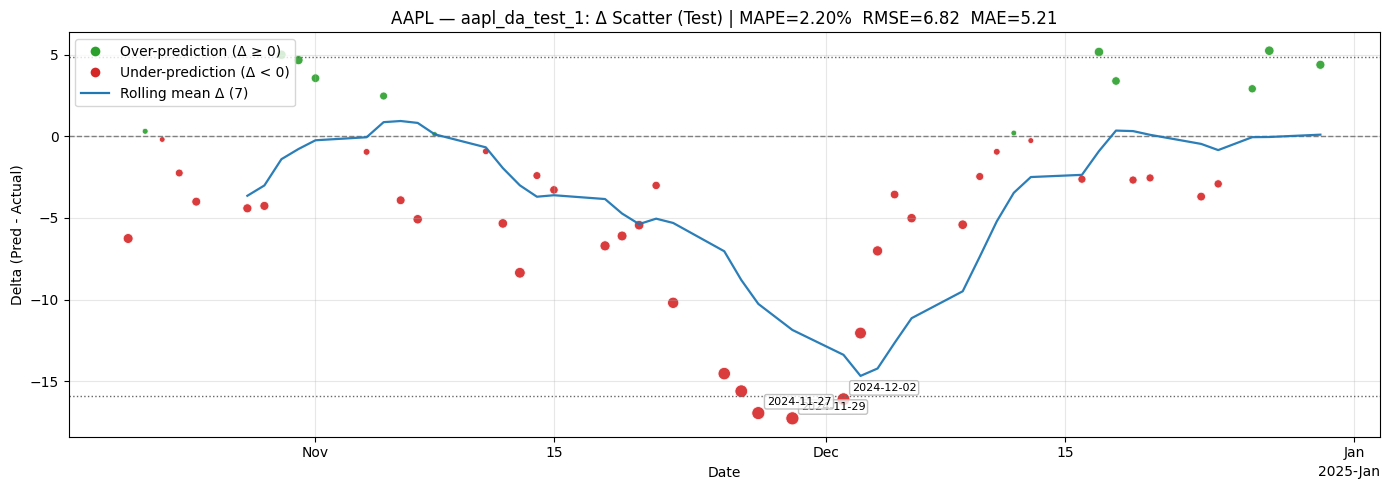

[delta] mean=-3.619, std=5.725, q05=-15.893, q95=4.858, n=49
[save] Delta scatter → runs\CNN\AAPL\20250829-214721\plots\AAPL_aapl_da_test_1_delta_scatter_test.png


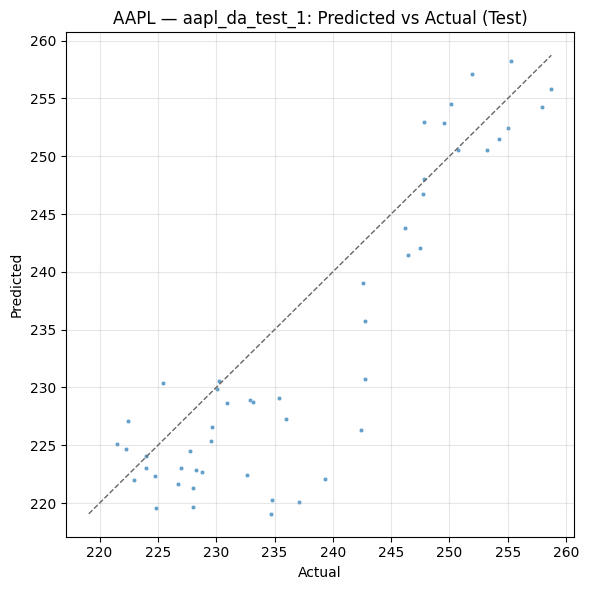

[save] Pred vs Actual → runs\CNN\AAPL\20250829-214721\plots\AAPL_aapl_da_test_1_pred_vs_actual_test.png
[save] Correlation matrix CSV → runs\CNN\AAPL\20250829-214721\tables\corr_aapl_da_test_1.csv


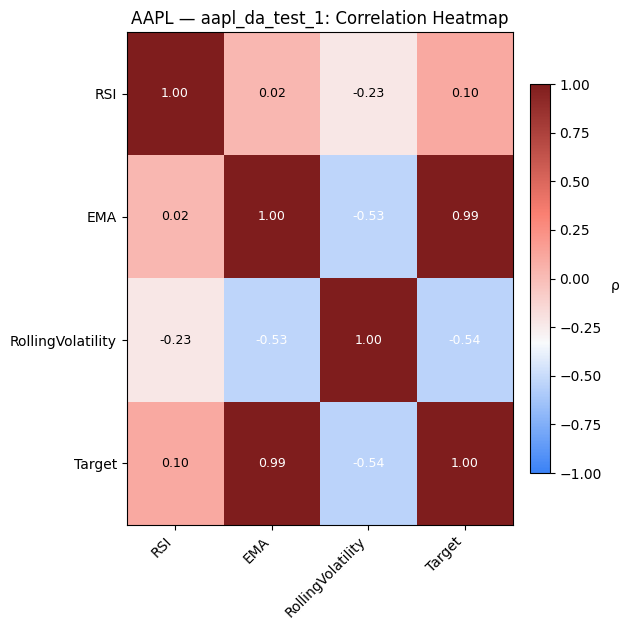

[save] Correlation heatmap → runs\CNN\AAPL\20250829-214721\plots\AAPL_aapl_da_test_1_corr_heatmap.png
   ✓ aapl_da_test_1: DA_test=0.5510 (Val=0.4082) | k=3 | PNL_ratio=2.28

▶️  Preparing set: aapl_da_test_2 | features=['RSI', 'BB_lower', 'MACD', 'SMA']
[prep] Features(k=4): ['RSI', 'BB_lower', 'MACD', 'SMA']
[prep] Windowed: X=(1247, 10, 4) (n,ws,k) | y=(1247,) | date_range=[2020-01-16..2024-12-30]
[split] n=1247 → Train=1147, Val=50, Test=50 (train_end=0.92, val_end=0.96)


c:\Users\hamir\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[model] window_size=10, n_features=4, epochs=60, batch_size=16, lr=0.001
[train] done in 9.9s



[metrics table]
Split    RMSE     MAE   MAPE     DA    n
Train  8.6553  6.2884 4.5050 0.5131 1147
  Val 13.2200 12.3858 5.4829 0.5102   50
 Test 12.3501 11.4549 4.8545 0.4286   50
[save] Metrics CSV → output\sets\AAPL_aapl_da_test_2_metrics.csv
[metrics] Train n=1147 | RMSE=8.6553 MAE=6.2884 MAPE=4.51% DA=0.5131
[metrics] Val   n=50 | RMSE=13.2200 MAE=12.3858 MAPE=5.48% DA=0.5102
[metrics] Test  n=50 | RMSE=12.3501 MAE=11.4549 MAPE=4.85% DA=0.4286
[delta] Test bias: mean Δ = -11.4376 | median Δ = -12.2823
[pnl] ratio=0.00 | wins=0 losses=0 | gain=0.00 loss=0.00
[save] Trade log CSV → output\pnl\pnl_research_style_AAPL.csv
[save] Appended Val/Test rows → results/CNN_results.csv


C:\Users\hamir\AppData\Local\Temp\ipykernel_25636\704205754.py:136: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = dt.datetime.utcnow().isoformat()


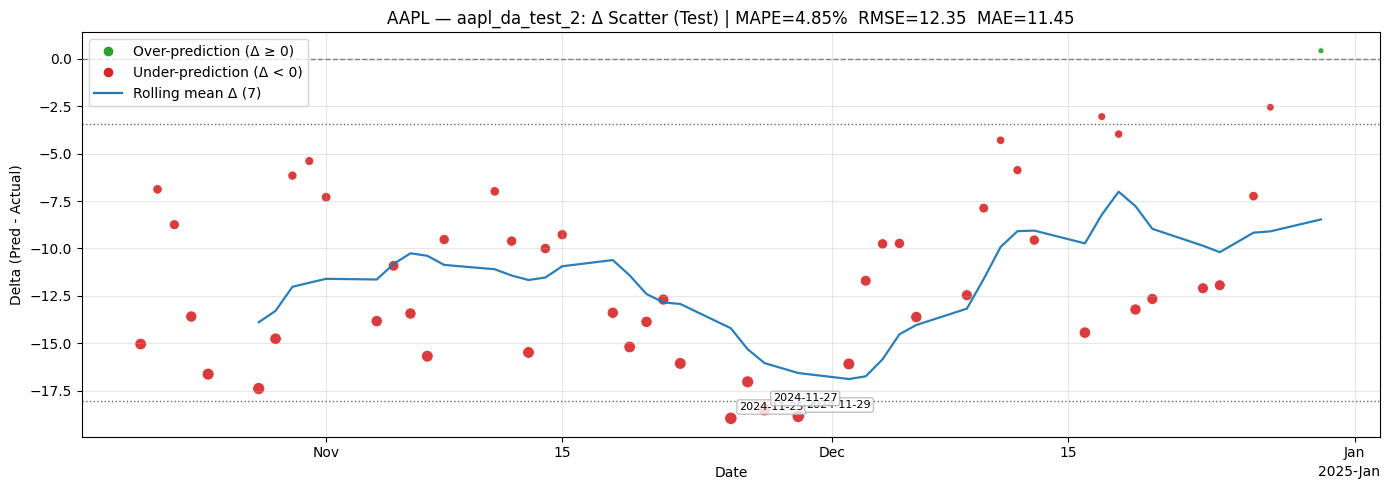

[delta] mean=-11.284, std=4.579, q05=-18.062, q95=-3.411, n=49
[save] Delta scatter → runs\CNN\AAPL\20250829-214721\plots\AAPL_aapl_da_test_2_delta_scatter_test.png


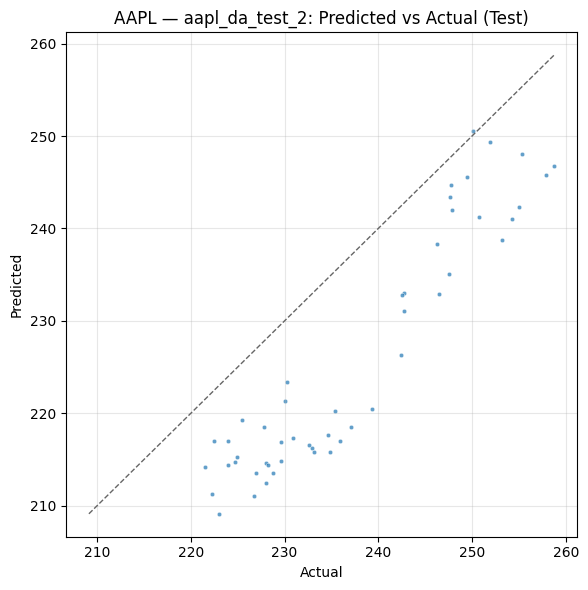

[save] Pred vs Actual → runs\CNN\AAPL\20250829-214721\plots\AAPL_aapl_da_test_2_pred_vs_actual_test.png
[save] Correlation matrix CSV → runs\CNN\AAPL\20250829-214721\tables\corr_aapl_da_test_2.csv


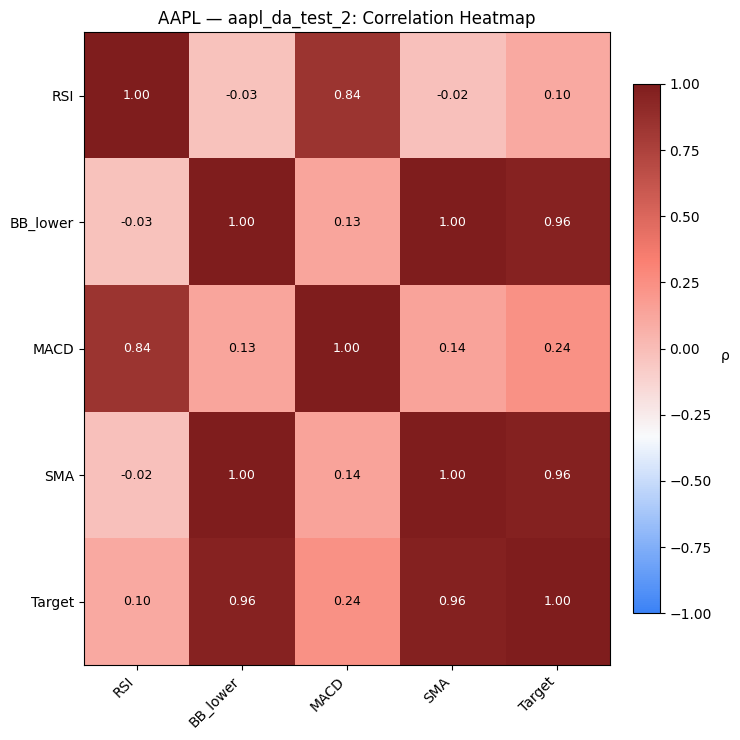

[save] Correlation heatmap → runs\CNN\AAPL\20250829-214721\plots\AAPL_aapl_da_test_2_corr_heatmap.png
   ✓ aapl_da_test_2: DA_test=0.4286 (Val=0.5102) | k=4 | PNL_ratio=0.00

▶️  Preparing set: aapl_pnl_test_1 | features=['BB_upper', 'RollingVolatility']
[prep] Features(k=2): ['BB_upper', 'RollingVolatility']
[prep] Windowed: X=(1247, 10, 2) (n,ws,k) | y=(1247,) | date_range=[2020-01-16..2024-12-30]
[split] n=1247 → Train=1147, Val=50, Test=50 (train_end=0.92, val_end=0.96)


c:\Users\hamir\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[model] window_size=10, n_features=2, epochs=60, batch_size=16, lr=0.001
[train] done in 10.4s



[metrics table]
Split    RMSE     MAE   MAPE     DA    n
Train  9.2035  5.9967 4.4846 0.5000 1147
  Val 13.9092 12.1350 5.3438 0.4694   50
 Test 14.5673 12.3868 5.1109 0.4694   50
[save] Metrics CSV → output\sets\AAPL_aapl_pnl_test_1_metrics.csv
[metrics] Train n=1147 | RMSE=9.2035 MAE=5.9967 MAPE=4.48% DA=0.5000
[metrics] Val   n=50 | RMSE=13.9092 MAE=12.1350 MAPE=5.34% DA=0.4694
[metrics] Test  n=50 | RMSE=14.5673 MAE=12.3868 MAPE=5.11% DA=0.4694
[delta] Test bias: mean Δ = -12.3290 | median Δ = -12.8247
[pnl] ratio=1343.02 | wins=1 losses=0 | gain=1343.02 loss=0.00
[save] Trade log CSV → output\pnl\pnl_research_style_AAPL.csv
[save] Appended Val/Test rows → results/CNN_results.csv


C:\Users\hamir\AppData\Local\Temp\ipykernel_25636\704205754.py:136: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = dt.datetime.utcnow().isoformat()


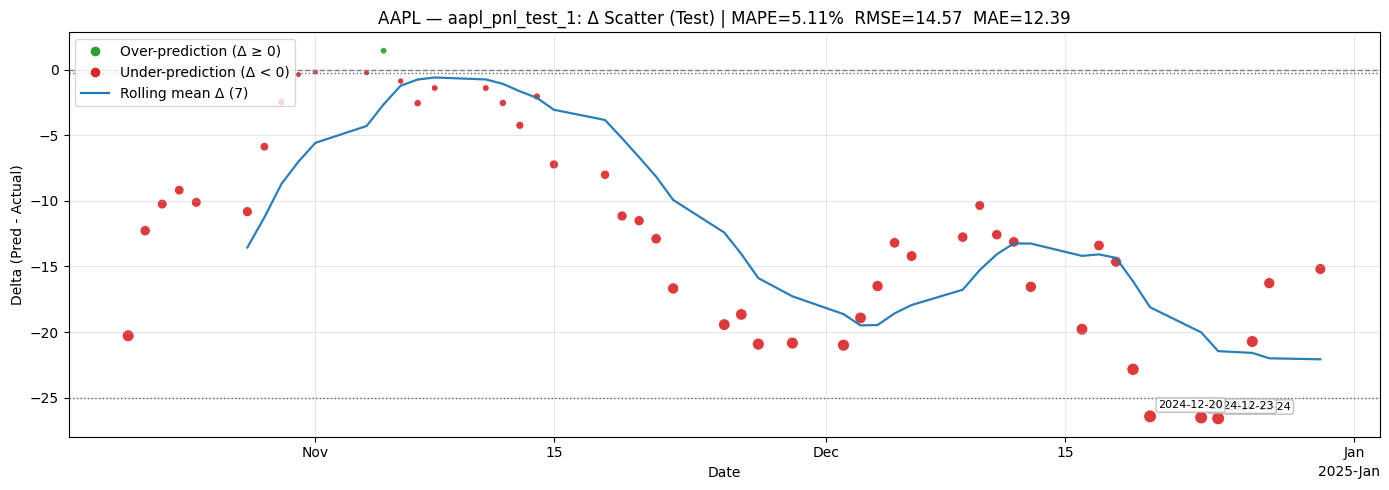

[delta] mean=-12.132, std=7.713, q05=-24.989, q95=-0.293, n=49
[save] Delta scatter → runs\CNN\AAPL\20250829-214721\plots\AAPL_aapl_pnl_test_1_delta_scatter_test.png


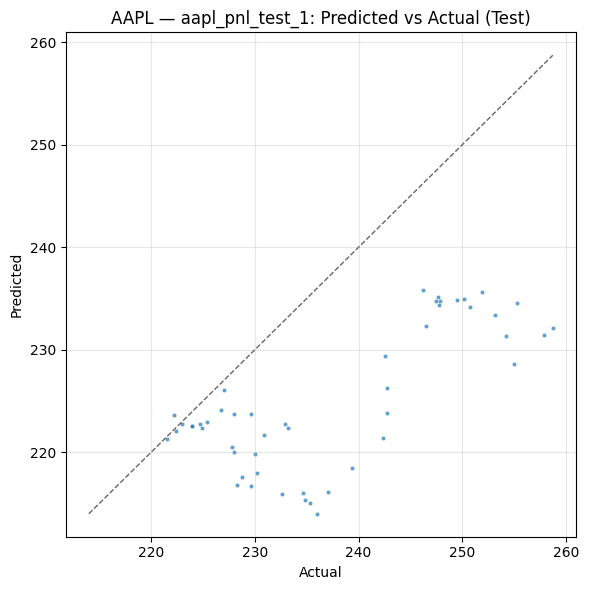

[save] Pred vs Actual → runs\CNN\AAPL\20250829-214721\plots\AAPL_aapl_pnl_test_1_pred_vs_actual_test.png
[save] Correlation matrix CSV → runs\CNN\AAPL\20250829-214721\tables\corr_aapl_pnl_test_1.csv


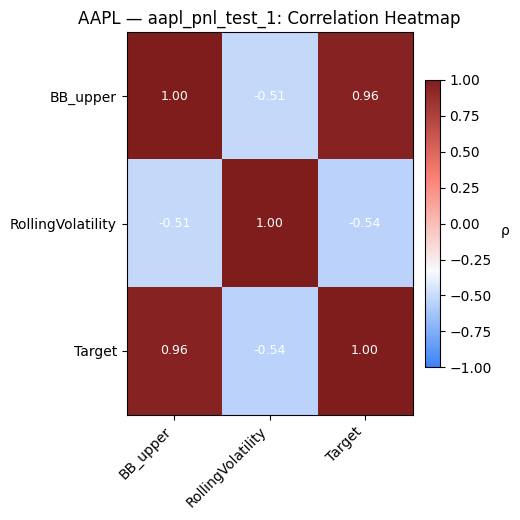

[save] Correlation heatmap → runs\CNN\AAPL\20250829-214721\plots\AAPL_aapl_pnl_test_1_corr_heatmap.png
   ✓ aapl_pnl_test_1: DA_test=0.4694 (Val=0.4694) | k=2 | PNL_ratio=1343.02

▶️  Preparing set: aapl_pnl_test_2 | features=['RSI', 'BB_upper', 'BB_lower', 'Momentum', 'MACD', 'SMA']
[prep] Features(k=6): ['RSI', 'BB_upper', 'BB_lower', 'Momentum', 'MACD', 'SMA']
[prep] Windowed: X=(1247, 10, 6) (n,ws,k) | y=(1247,) | date_range=[2020-01-16..2024-12-30]
[split] n=1247 → Train=1147, Val=50, Test=50 (train_end=0.92, val_end=0.96)


c:\Users\hamir\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[model] window_size=10, n_features=6, epochs=60, batch_size=16, lr=0.001
[train] done in 10.3s



[metrics table]
Split    RMSE     MAE   MAPE     DA    n
Train  8.0725  5.6458 4.0539 0.5314 1147
  Val 11.2855 10.2153 4.5343 0.5102   50
 Test 11.2241 10.0959 4.2256 0.3878   50
[save] Metrics CSV → output\sets\AAPL_aapl_pnl_test_2_metrics.csv
[metrics] Train n=1147 | RMSE=8.0725 MAE=5.6458 MAPE=4.05% DA=0.5314
[metrics] Val   n=50 | RMSE=11.2855 MAE=10.2153 MAPE=4.53% DA=0.5102
[metrics] Test  n=50 | RMSE=11.2241 MAE=10.0959 MAPE=4.23% DA=0.3878
[delta] Test bias: mean Δ = -10.0959 | median Δ = -10.0929
[pnl] ratio=0.00 | wins=0 losses=0 | gain=0.00 loss=0.00
[save] Trade log CSV → output\pnl\pnl_research_style_AAPL.csv
[save] Appended Val/Test rows → results/CNN_results.csv


C:\Users\hamir\AppData\Local\Temp\ipykernel_25636\704205754.py:136: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = dt.datetime.utcnow().isoformat()


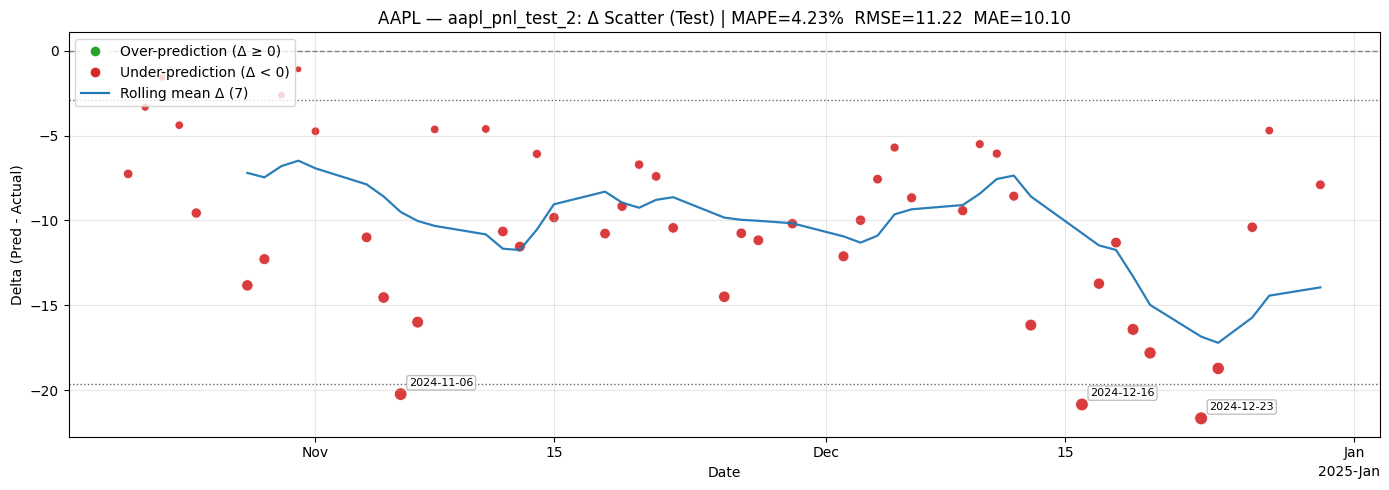

[delta] mean=-10.089, std=4.954, q05=-19.635, q95=-2.904, n=49
[save] Delta scatter → runs\CNN\AAPL\20250829-214721\plots\AAPL_aapl_pnl_test_2_delta_scatter_test.png


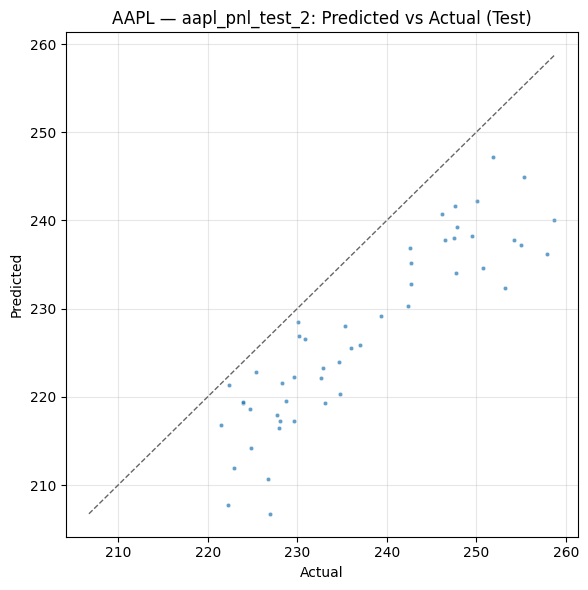

[save] Pred vs Actual → runs\CNN\AAPL\20250829-214721\plots\AAPL_aapl_pnl_test_2_pred_vs_actual_test.png
[save] Correlation matrix CSV → runs\CNN\AAPL\20250829-214721\tables\corr_aapl_pnl_test_2.csv


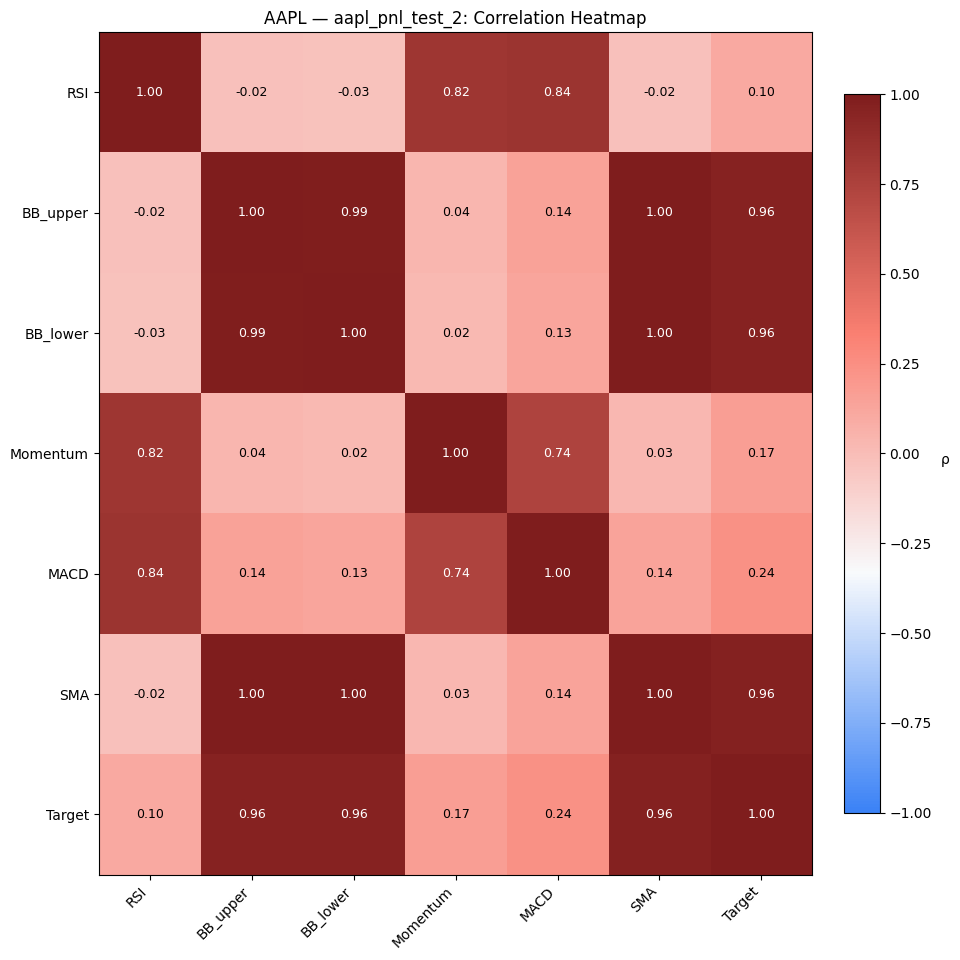

[save] Correlation heatmap → runs\CNN\AAPL\20250829-214721\plots\AAPL_aapl_pnl_test_2_corr_heatmap.png
   ✓ aapl_pnl_test_2: DA_test=0.3878 (Val=0.5102) | k=6 | PNL_ratio=0.00

=== Leaderboard (top 5 by DA_test, then PNL) ===
       set_name  DA_test   DA_val  RMSE_test  k  PNL_ratio  PNL_wins  PNL_losses
 aapl_da_test_1 0.551020 0.408163   6.815922  3       2.28         3           1
aapl_pnl_test_1 0.469388 0.469388  14.567289  2    1343.02         1           0
 aapl_da_test_2 0.428571 0.510204  12.350075  4       0.00         0           0
aapl_pnl_test_2 0.387755 0.510204  11.224055  6       0.00         0           0

🏆 Best CANDIDATE by TEST DA: aapl_da_test_1  (DA_test=0.5510)
[save] Leaderboard CSV → output\sets\AAPL_cnn_candidate_results.csv


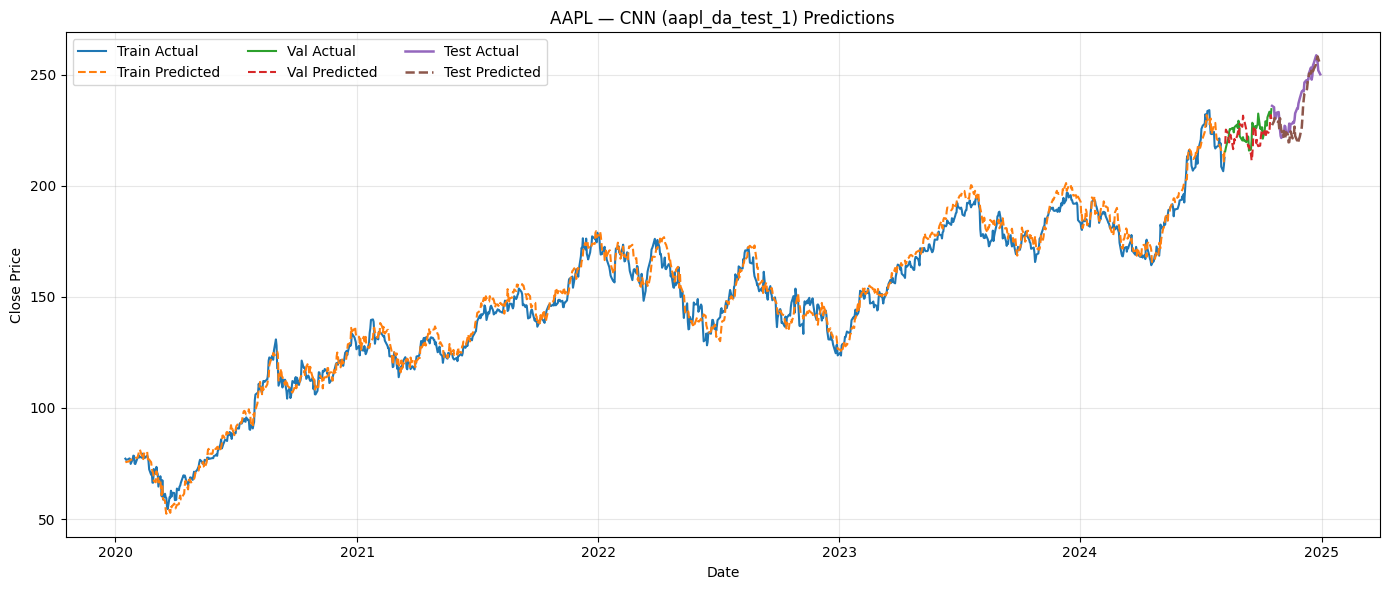

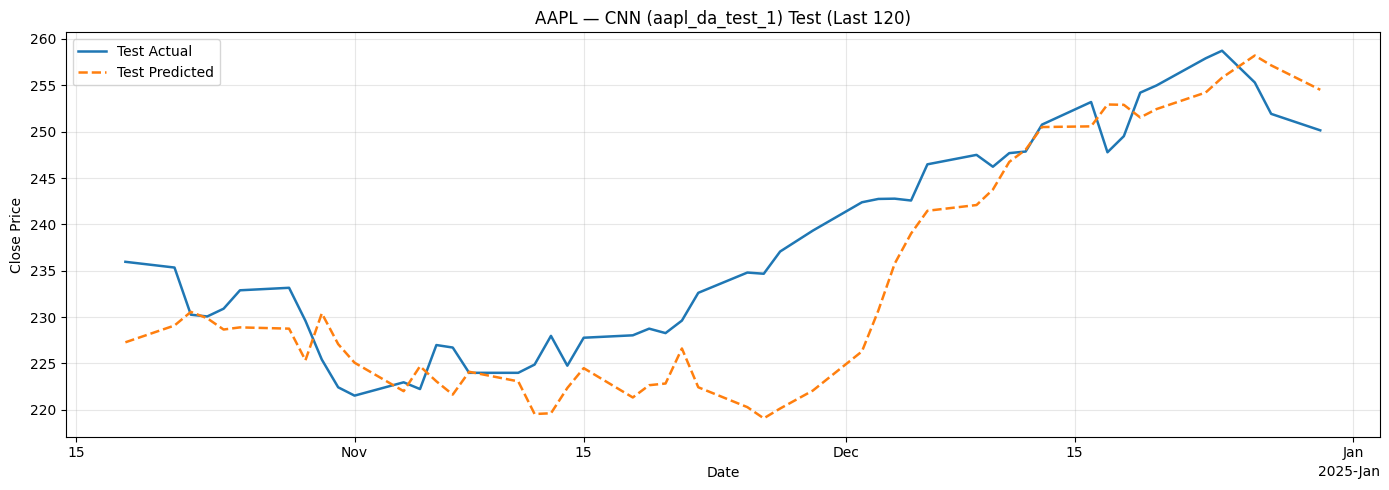

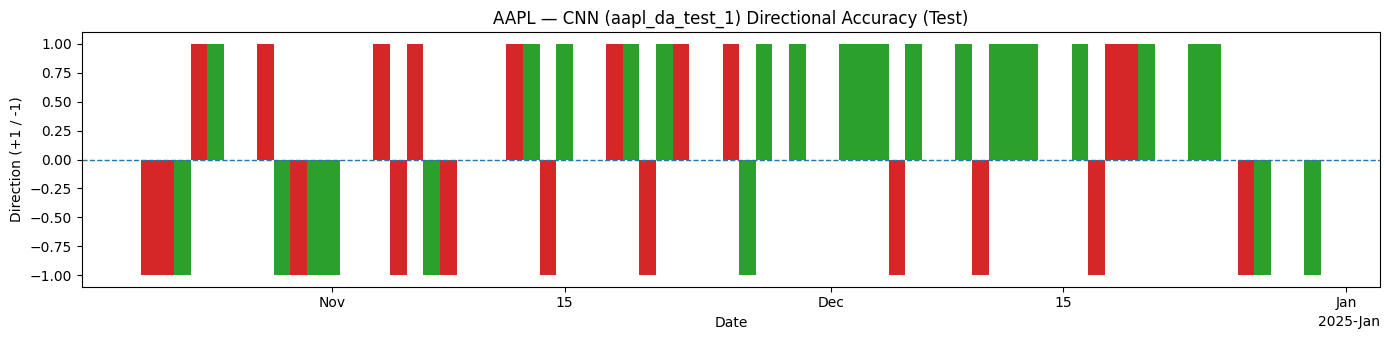

In [12]:
# === 9) Train & evaluate across candidate sets (with P&L), print-rich & robust ===
import time

# Reuse a saver if already created
try:
    saver
except NameError:
    saver = RunSaver("CNN", ticker)
saver.note("Starting candidate evaluation")

CANDIDATE_OUT_DIR = Path("output/sets")
CANDIDATE_OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Backtest / PnL config ---
bt_cfg = (config.get("backtest") or {})
INITIAL_CASH = float(bt_cfg.get("initial_cash", 80_000))
PNL_OUT_DIR  = Path(bt_cfg.get("pnl_output_folder", str(saver.tables / "pnl")))
PNL_OUT_DIR.mkdir(parents=True, exist_ok=True)

def _build_cnn_safe(window_size, n_feats, lr):
    """Handle builders that may/may not take 'learning_rate'."""
    try:
        return build_cnn_model(window_size, n_feats, lr)
    except TypeError:
        return build_cnn_model(window_size, n_feats)

def eval_candidate_set(feat_cols, set_name):
    """Train CNN on one candidate set and return split metrics + artifacts."""
    print(f"\n▶️  Preparing set: {set_name} | features={feat_cols}")
    # ---- prep ----
    dates_s, X_s, y_s, scaler_y_s, feature_order = prepare_data_for_features(feat_cols)
    d_tr, d_va, d_te, X_tr, X_va, X_te, y_tr, y_va, y_te = split_by_percent(
        dates_s, X_s, y_s, train_end=TRAIN_END, val_end=VAL_END
    )

    # ---- train ----
    set_seed(42)
    model = _build_cnn_safe(window_size, X_s.shape[2], learning_rate)
    print(f"[model] window_size={window_size}, n_features={X_s.shape[2]}, "
          f"epochs={epochs}, batch_size={batch_size}, lr={learning_rate}")
    t0 = time.time()
    _ = model.fit(X_tr, y_tr, validation_data=(X_va, y_va),
                  epochs=epochs, batch_size=batch_size, verbose=0)
    train_secs = time.time() - t0
    print(f"[train] done in {train_secs:.1f}s")

    # ---- predictions (inverse-scale) ----
    tr_pred = scaler_y_s.inverse_transform(model.predict(X_tr, verbose=0)).ravel()
    va_pred = scaler_y_s.inverse_transform(model.predict(X_va, verbose=0)).ravel()
    te_pred = scaler_y_s.inverse_transform(model.predict(X_te, verbose=0)).ravel()

    tr_true = scaler_y_s.inverse_transform(y_tr.reshape(-1,1)).ravel()
    va_true = scaler_y_s.inverse_transform(y_va.reshape(-1,1)).ravel()
    te_true = scaler_y_s.inverse_transform(y_te.reshape(-1,1)).ravel()

    # ---- metrics ----
    rmse_tr, mae_tr = compute_metrics(tr_true, tr_pred)
    rmse_va, mae_va = compute_metrics(va_true, va_pred)
    rmse_te, mae_te = compute_metrics(te_true, te_pred)

    da_tr  = compute_directional_accuracy(tr_true, tr_pred)
    da_va  = compute_directional_accuracy(va_true, va_pred)
    da_te  = compute_directional_accuracy(te_true, te_pred)

    mape_tr = mape(tr_true, tr_pred)
    mape_va = mape(va_true, va_pred)
    mape_te = mape(te_true, te_pred)
    # --- save & print the split metrics table ---
    metrics_df = save_split_metrics_table(
    set_name, ticker,
    d_tr, tr_true, tr_pred,
    d_va, va_true, va_pred,
    d_te, te_true, te_pred,
    out_dir=str(CANDIDATE_OUT_DIR)
)

    print(f"[metrics] Train n={len(tr_true)} | RMSE={rmse_tr:.4f} MAE={mae_tr:.4f} MAPE={mape_tr:.2f}% DA={da_tr:.4f}")
    print(f"[metrics] Val   n={len(va_true)} | RMSE={rmse_va:.4f} MAE={mae_va:.4f} MAPE={mape_va:.2f}% DA={da_va:.4f}")
    print(f"[metrics] Test  n={len(te_true)} | RMSE={rmse_te:.4f} MAE={mae_te:.4f} MAPE={mape_te:.2f}% DA={da_te:.4f}")

    # delta bias summary (Pred - Actual)
    delta_test = te_pred - te_true
    print(f"[delta] Test bias: mean Δ = {delta_test.mean():.4f} | median Δ = {np.median(delta_test):.4f}")

    # ---- P&L on TEST (only if target==price) ----
    pnl_result = None
    if globals().get("t_type", "price") == "price":
        pnl_result, trade_log_df = simulate_pnl(
            te_true, te_pred,
            initial_cash=INITIAL_CASH,
            ticker=f"{ticker}_{set_name}",
            output_folder=str(PNL_OUT_DIR)
        )
        # Save via RunSaver as well
        saver.save_json(pnl_result, f"pnl_{set_name}")
        saver.save_df(trade_log_df, f"pnl_trades_{set_name}")
        print(f"[pnl] ratio={pnl_result['P&L Ratio']:.2f} | "
              f"wins={pnl_result['Winning Trades']} losses={pnl_result['Losing Trades']} | "
              f"gain={pnl_result['Total Gain']:.2f} loss={pnl_result['Total Loss']:.2f}")
        print(f"[save] Trade log CSV → {PNL_OUT_DIR / ('pnl_research_style_' + ticker + '.csv')}")
    else:
        print("[pnl] Skipped (target.type is not 'price').")

    # ---- save per-set artifacts ----
    model_path = saver.save_model(model, f"CNN_{ticker}_{set_name}")
    saver.save_scalers(scaler_y=scaler_y_s, name=f"y_{set_name}")

    saver.save_df(pd.DataFrame({
        "Date": d_te, "Actual": te_true, "Predicted": te_pred, "Delta": te_pred - te_true
    }), f"deltas_{set_name}")

    saver.save_df(pd.DataFrame({
        "Date": np.concatenate([d_tr, d_va, d_te]),
        "Split": (["Train"]*len(d_tr)) + (["Val"]*len(d_va)) + (["Test"]*len(d_te)),
        "Actual": np.concatenate([tr_true, va_true, te_true]),
        "Predicted": np.concatenate([tr_pred, va_pred, te_pred]),
    }), f"preds_{set_name}_all_splits")

    saver.save_json({
        "ticker": ticker,
        "set_name": set_name,
        "features": feat_cols,
        "k": len(feat_cols),
        "metrics": {
            "train": {"RMSE": float(rmse_tr), "MAE": float(mae_tr), "MAPE": float(mape_tr), "DA": float(da_tr)},
            "val":   {"RMSE": float(rmse_va), "MAE": float(mae_va), "MAPE": float(mape_va), "DA": float(da_va)},
            "test":  {"RMSE": float(rmse_te), "MAE": float(mae_te), "MAPE": float(mape_te), "DA": float(da_te)},
        },
        "model_path": str(model_path),
        "train_seconds": float(train_secs),
        "pnl": pnl_result if pnl_result is not None else None,
    }, f"summary_{set_name}")

    # ---- also append concise Val/Test rows to global results CSV ----
    try:
        append_per_set_summary(
            ticker=ticker, set_name=set_name, k=len(feat_cols),
            da_val=float(da_va), rmse_val=float(rmse_va), mae_val=float(mae_va), mape_val=float(mape_va),
            da_test=float(da_te), rmse_test=float(rmse_te), mae_test=float(mae_te), mape_test=float(mape_te),
            window_size=window_size, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
            train_end=TRAIN_END, val_end=VAL_END, result_file=RESULT_FILE_CNN
        )
        print(f"[save] Appended Val/Test rows → {RESULT_FILE_CNN}")
    except NameError:
        fallback_csv = "results/cnn_results.csv"
        os.makedirs(os.path.dirname(fallback_csv), exist_ok=True)
        append_per_set_summary(
            ticker=ticker, set_name=set_name, k=len(feat_cols),
            da_val=float(da_va), rmse_val=float(rmse_va), mae_val=float(mae_va), mape_val=float(mape_va),
            da_test=float(da_te), rmse_test=float(rmse_te), mae_test=float(mae_te), mape_test=float(mape_te),
            window_size=window_size, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
            train_end=TRAIN_END, val_end=VAL_END, result_file=fallback_csv
        )
        print(f"[save] Appended Val/Test rows → {fallback_csv}")

    # return for leaderboard
    result_row = {
        "ticker": ticker,
        "set_name": set_name,
        "features": ",".join(feat_cols),
        "k": len(feat_cols),
        "RMSE_val": float(rmse_va), "MAE_val": float(mae_va), "MAPE_val": float(mape_va), "DA_val": float(da_va),
        "RMSE_test": float(rmse_te), "MAE_test": float(mae_te), "MAPE_test": float(mape_te), "DA_test": float(da_te),
        "model_path": str(model_path),
        "train_seconds": float(train_secs),
    }
    # add P&L stats to result row if available
    if pnl_result is not None:
        result_row.update({
            "PNL_ratio": float(pnl_result["P&L Ratio"]),
            "PNL_total_gain": float(pnl_result["Total Gain"]),
            "PNL_total_loss": float(pnl_result["Total Loss"]),
            "PNL_wins": int(pnl_result["Winning Trades"]),
            "PNL_losses": int(pnl_result["Losing Trades"]),
            "Final_Cash": float(pnl_result["Final Cash"]),
        })

    artifacts = dict(
        dates=(d_tr, d_va, d_te),
        truth=(tr_true, va_true, te_true),
        preds=(tr_pred, va_pred, te_pred),
        scaler_y=scaler_y_s,
        model=model,
        feature_order=feature_order,
        pnl=pnl_result
    )

    # ---- extra visuals: delta scatter, Pred vs Actual, & correlations ----
    delta_scatter_path = str(saver.plots / f"{ticker}_{set_name}_delta_scatter_test.png")
    plot_delta_scatter_painted(
    d_te, te_true, te_pred,
    title=(f"{ticker} — {set_name}: Δ Scatter (Test) | "
           f"MAPE={metrics_df.loc[metrics_df.Split=='Test','MAPE'].item():.2f}%  "
           f"RMSE={metrics_df.loc[metrics_df.Split=='Test','RMSE'].item():.2f}  "
           f"MAE={metrics_df.loc[metrics_df.Split=='Test','MAE'].item():.2f}"),
    save_path=delta_scatter_path,
    rolling_window=7,
    top_k_annotate=3,
    color_by="sign",
    add_summary=True
)
    print(f"[save] Delta scatter → {delta_scatter_path}")


    pva_path = str(saver.plots / f"{ticker}_{set_name}_pred_vs_actual_test.png")
    plot_pred_vs_actual(
        te_true, te_pred,
        title=f"{ticker} — {set_name}: Predicted vs Actual (Test)",
        save_path=pva_path
    )
    print(f"[save] Pred vs Actual → {pva_path}")

    corr = compute_corr_matrix_for_set(df, feat_cols, include_target=True, target_col="Target")
    saver.save_df(corr, f"corr_{set_name}")
    corr_csv_path = str(saver.tables / f"corr_{set_name}.csv")
    print(f"[save] Correlation matrix CSV → {corr_csv_path}")

    corr_heatmap_path = str(saver.plots / f"{ticker}_{set_name}_corr_heatmap.png")
    plot_corr_heatmap(corr, title=f"{ticker} — {set_name}: Correlation Heatmap", save_path=corr_heatmap_path)
    print(f"[save] Correlation heatmap → {corr_heatmap_path}")

    return result_row, artifacts

# --- evaluate all candidates (skip if columns missing) ---
print(f"\n=== Evaluating {len(CANDIDATE_SETS)} candidate set(s) for {ticker} ===")
candidate_rows, candidate_artifacts = [], {}

for set_name, cols in CANDIDATE_SETS.items():
    missing = [c for c in cols if c not in df.columns]
    if missing:
        print(f"⚠️  Skipping {set_name}: missing columns {missing}")
        continue
    try:
        row, arts = eval_candidate_set(cols, set_name)
        candidate_rows.append(row)
        candidate_artifacts[set_name] = arts
        msg = f"   ✓ {set_name}: DA_test={row['DA_test']:.4f} (Val={row['DA_val']:.4f}) | k={row['k']}"
        if "PNL_ratio" in row:
            msg += f" | PNL_ratio={row['PNL_ratio']:.2f}"
        print(msg)
    except Exception as e:
        print(f"   ✗ {set_name}: ERROR during training/eval → {e}")

if len(candidate_rows) == 0:
    raise RuntimeError("No candidate sets were evaluated. Check indicator availability and data length.")

# --- leaderboard + winner (by TEST DA; P&L shown for reference) ---
cand_df = pd.DataFrame(candidate_rows).sort_values(["DA_test", "PNL_ratio" if "PNL_ratio" in candidate_rows[0] else "DA_test"], ascending=False).reset_index(drop=True)
cand_csv = CANDIDATE_OUT_DIR / f"{ticker}_cnn_candidate_results.csv"
cand_df.to_csv(cand_csv, index=False)
saver.save_df(cand_df, "candidate_results")

best_cand = cand_df.iloc[0]
best_set_name = best_cand["set_name"]
print("\n=== Leaderboard (top 5 by DA_test, then PNL) ===")
keep_cols = [c for c in ["set_name","DA_test","DA_val","RMSE_test","k","PNL_ratio","PNL_wins","PNL_losses"] if c in cand_df.columns]
print(cand_df[keep_cols].head(5).to_string(index=False))
print(f"\n🏆 Best CANDIDATE by TEST DA: {best_set_name}  (DA_test={best_cand['DA_test']:.4f})")
print(f"[save] Leaderboard CSV → {cand_csv}")
saver.save_json(best_cand.to_dict(), "candidate_winner")

# --- plots for winner (saved into run folder) ---
arts = candidate_artifacts[best_set_name]
(d_tr, d_va, d_te) = arts["dates"]
(tr_true, va_true, te_true) = arts["truth"]
(tr_pred, va_pred, te_pred) = arts["preds"]

plot_predictions(
    d_tr, tr_true, tr_pred,
    d_va, va_true, va_pred,
    d_te, te_true, te_pred,
    title=f"{ticker} — CNN ({best_set_name}) Predictions",
    save_path=str(saver.plots / f"{ticker}_{best_set_name}_predictions.png")
)
plot_test_zoomed(
    d_te, te_true, te_pred,
    last_n=120,
    title=f"{ticker} — CNN ({best_set_name}) Test (Last 120)",
    save_path=str(saver.plots / f"{ticker}_{best_set_name}_test_zoom.png")
)
plot_direction_accuracy_bars(
    d_te, te_true, te_pred,
    title=f"{ticker} — CNN ({best_set_name}) Directional Accuracy (Test)",
    save_path=str(saver.plots / f"{ticker}_{best_set_name}_dir_accuracy.png")
)

# --- hand-off variables ---
cand_best_set_name = best_set_name
cand_best_feats    = CANDIDATE_SETS[best_set_name]
model_best         = arts["model"]
feature_names      = arts["feature_order"]
scaler_y_best      = arts["scaler_y"]
dates_s            = np.concatenate([d_tr, d_va, d_te])

saver.note(f"Finished candidate evaluation. Winner: {cand_best_set_name}")


In [13]:
# === Optional: refit the winning set on Train+Val ===
best_feats = CANDIDATE_SETS[best_set_name]

# Rebuild data & splits for the best set
dates_s, X_s, y_s, scaler_y_s, feature_order = prepare_data_for_features(best_feats)
d_tr, d_va, d_te, X_tr, X_va, X_te, y_tr, y_va, y_te = split_by_percent(
    dates_s, X_s, y_s, train_end=TRAIN_END, val_end=VAL_END
)

# Concatenate Train+Val for "full" training after selection
X_tv = np.concatenate([X_tr, X_va], axis=0)
y_tv = np.concatenate([y_tr, y_va], axis=0)

final_model = build_cnn_model(X_s.shape[2], window_size)
final_model.fit(X_tv, y_tv, epochs=epochs, batch_size=batch_size, verbose=0)

# Evaluate on untouched Test
te_pred_final = scaler_y_s.inverse_transform(final_model.predict(X_te, verbose=0)).ravel()
te_true_final = scaler_y_s.inverse_transform(y_te.reshape(-1,1)).ravel()

rmse_f, mae_f = compute_metrics(te_true_final, te_pred_final)
mape_f = mape(te_true_final, te_pred_final)
da_f   = compute_directional_accuracy(te_true_final, te_pred_final)

print(f"[final TRAIN+VAL] Test | RMSE={rmse_f:.4f} MAE={mae_f:.4f} MAPE={mape_f:.2f}% DA={da_f:.4f}")

# Save the final model
final_path = saver.save_model(final_model, f"CNN_{ticker}_{best_set_name}_FINAL_TV")
saver.save_json({
    "ticker": ticker, "set_name": best_set_name, "k": len(best_feats),
    "final_model_path": str(final_path),
    "test_metrics_after_refit": {"RMSE": float(rmse_f), "MAE": float(mae_f), "MAPE": float(mape_f), "DA": float(da_f)}
}, f"final_refit_{best_set_name}")


[prep] Features(k=3): ['RSI', 'EMA', 'RollingVolatility']
[prep] Windowed: X=(1247, 10, 3) (n,ws,k) | y=(1247,) | date_range=[2020-01-16..2024-12-30]
[split] n=1247 → Train=1147, Val=50, Test=50 (train_end=0.92, val_end=0.96)


c:\Users\hamir\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv1d_1" is incompatible with the layer: expected axis -1 of input shape to have value 10, but received input with shape (None, 10, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 10, 3), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:
# AFTER you’ve printed/logged the final Test metrics:
deploy_model = _build_cnn_safe(X_s.shape[2])
deploy_model.fit(X_s, y_s, epochs=epochs, batch_size=batch_size, verbose=0)

deploy_path = saver.save_model(deploy_model, f"CNN_{ticker}_{best_set_name}_FINAL_ALL")
saver.save_json({
    "ticker": ticker,
    "set_name": best_set_name,
    "k": len(best_feats),
    "final_deploy_model_path": str(deploy_path),
    "note": "Trained on Train+Val+Test for deployment; not used for unbiased evaluation."
}, f"final_deploy_all_{best_set_name}")
